<a href="https://colab.research.google.com/github/arbiter1elegantiae/kaf-nets/blob/master/PGD_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#!pip install --upgrade tf-nightly

     |████████████████████████████████| 322.8MB 48kB/s 
     |████████████████████████████████| 460kB 37.9MB/s 
     |████████████████████████████████| 6.5MB 37.8MB/s 


In [11]:
!pip install tf-nightly==2.3.0-dev20200521

     |████████████████████████████████| 523.3MB 33kB/s 
  Found existing installation: tf-nightly 2.4.0.dev20200708
    Uninstalling tf-nightly-2.4.0.dev20200708:
      Successfully uninstalled tf-nightly-2.4.0.dev20200708


In [11]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

import activationsf

time: 1.85 ms


In [12]:
tf.version.VERSION

'2.3.0-dev20200521'

time: 2.6 ms


In [3]:
#!pip install adversarial-robustness-toolbox

In [13]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/ 255.0, x_test/ 255.0

time: 1.22 s


In [14]:
# Load model
rob_elu_cnn = tf.keras.models.load_model('/content/elu_cnn_robust_fbf')

time: 1.75 s


In [15]:
# Evaluation on vanilla test/train set
rob_elu_cnn.evaluate(x_train, y_train, batch_size=128)
rob_elu_cnn.evaluate(x_test, y_test, batch_size=128)

79/79 [==============================] - 1s 12ms/step - loss: 1.0319 - accuracy: 0.6651


[1.0319466590881348, 0.6650999784469604]

time: 6.82 s


In [16]:
from art.classifiers import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent

# Wrap the model in a TensorFlowV2Classifier object
rob_elu_cnn_art = TensorFlowV2Classifier(model=rob_elu_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))

time: 2.98 ms


In [17]:
# Set up a PGD attack w/ parameters as described in FBF ref paper
pgd = ProjectedGradientDescent(estimator= rob_elu_cnn_art, eps= 8/255, eps_step=2/255, max_iter=40, num_random_init=10, norm=np.inf)

time: 1.42 ms


In [8]:
# If loaded, every output of subsequent cell execution will include the time in min and sec it took to execute it.
#!pip install ipython-autotime
%load_ext autotime

In [18]:
test_sample_ids = np.random.randint(10000, size=200)
x_test_sample = x_test[test_sample_ids, :, :, :]
rob_elu_test_adv = pgd.generate(x_test_sample)

time: 1min 28s


In [19]:
train_sample_ids = np.random.randint(50000, size=200)
x_train_sample = x_train[train_sample_ids, :, :, :]
rob_elu_train_adv = pgd.generate(x_train_sample)

time: 1min 27s


In [21]:
np.save('/content/rob_elu_test_pgd.npy', rob_elu_test_adv)
np.save('/content/rob_elu_train_pgd.npy', rob_elu_train_adv)

time: 56.2 ms


In [32]:
def find_original_img(perturbed_img, set='test'):
    """Retrieve original image id given an adversarial example""" 
    min_diff = np.math.inf
    index = 0
    
    if set == 'test':
      for i in range(0, x_test.shape[0]):
          diff = np.sum(abs(perturbed_img - x_test[i]))
          if diff < min_diff:
              min_diff = diff
              index = i
    
    elif set =='train':
      for i in range(0, x_train.shape[0]):
        diff = np.sum(abs(perturbed_img - x_train[i]))
        if diff < min_diff:
            min_diff = diff
            index = i
    else:
      print('Arg set must be either train or test')

            
    return index

time: 16.4 ms


In [23]:
# CIFAR10 Classes
classes = ['airplane', 
           'automobile', 
            'bird', 
            'cat', 
            'deer', 
            'dog', 
            'frog', 
            'horse', 
            'ship', 
            'truck']

time: 1.54 ms


In [35]:
def attack_succeed(original_img, idx, perturbed_img, model, plot = False, set='test'):
    """
        Return 0 if the model has been fooled 1 otherwise. Plot True if you want more info on the error margin
    """

    if plot:
        # Plot original img alongside with the perturbed one
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(original_img);
        ax[0].title.set_text('Original')
        ax[0].axis('off')
        ax[1].imshow(perturbed_img)
        ax[1].title.set_text('Perturbed')
        ax[1].axis('off')
        plt.show()
        plt.close()

    # Predict
    perturbed_img = tf.expand_dims(perturbed_img, 0)

    if set=='test':
      original = classes[y_test[idx][0]]
    elif set =='train':
      original = classes[y_train[idx][0]]
    else:
      print('Arg set must be either train or test')

    perturbed = classes[np.argmax(model.predict(perturbed_img))]

    if plot:
        print("Real class: {}".format(original))
        print("Predicted class: {} with {} confidence".format(perturbed , round(np.max(model.predict(perturbed_img)) * 100)) )

    return (original == perturbed)

time: 20.3 ms


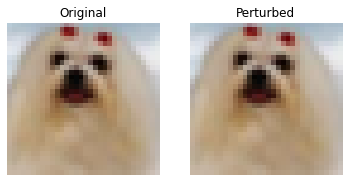

Real class: dog
Predicted class: bird with 34.0 confidence


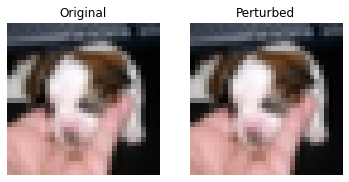

Real class: dog
Predicted class: dog with 57.0 confidence


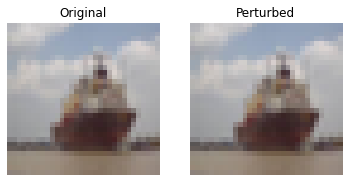

Real class: ship
Predicted class: ship with 64.0 confidence


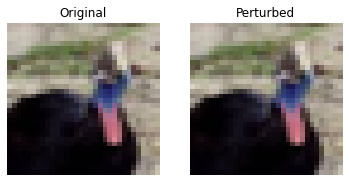

Real class: bird
Predicted class: automobile with 17.0 confidence


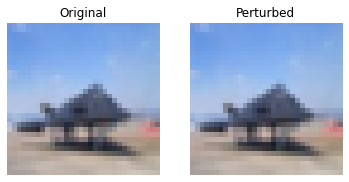

Real class: airplane
Predicted class: airplane with 82.0 confidence


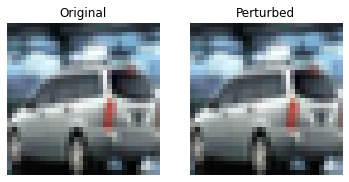

Real class: automobile
Predicted class: automobile with 85.0 confidence


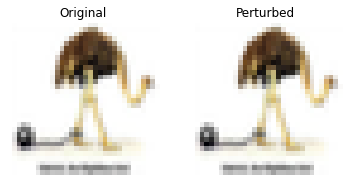

Real class: bird
Predicted class: cat with 33.0 confidence


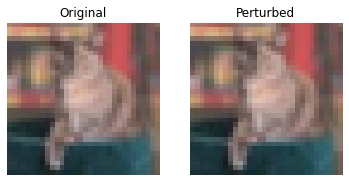

Real class: cat
Predicted class: frog with 25.0 confidence


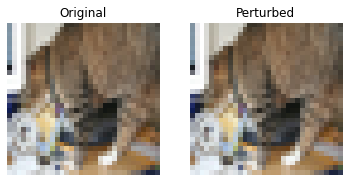

Real class: cat
Predicted class: frog with 25.0 confidence


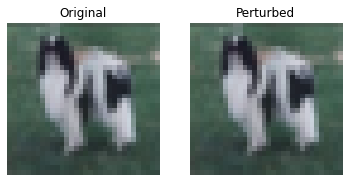

Real class: dog
Predicted class: dog with 46.0 confidence


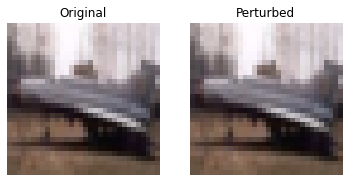

Real class: airplane
Predicted class: truck with 38.0 confidence


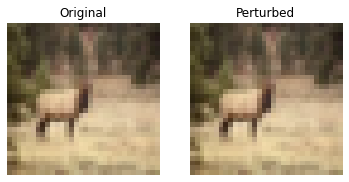

Real class: deer
Predicted class: deer with 47.0 confidence


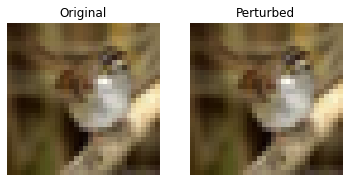

Real class: bird
Predicted class: frog with 43.0 confidence


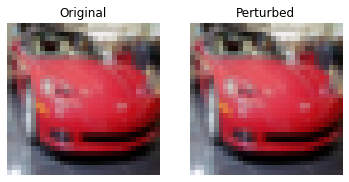

Real class: automobile
Predicted class: automobile with 74.0 confidence


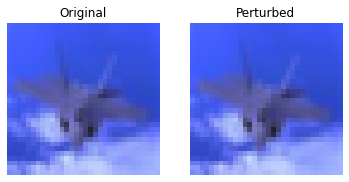

Real class: airplane
Predicted class: airplane with 79.0 confidence


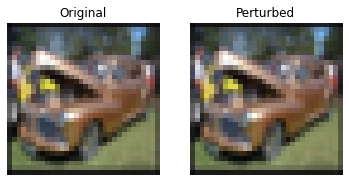

Real class: automobile
Predicted class: automobile with 38.0 confidence


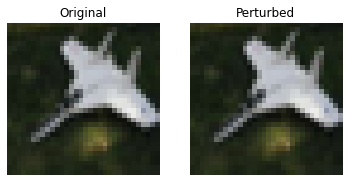

Real class: airplane
Predicted class: airplane with 36.0 confidence


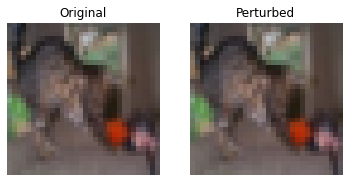

Real class: cat
Predicted class: frog with 34.0 confidence


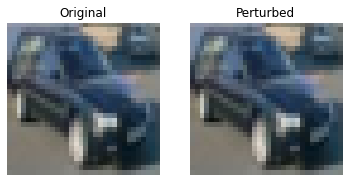

Real class: automobile
Predicted class: automobile with 67.0 confidence


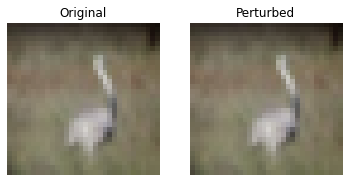

Real class: bird
Predicted class: deer with 30.0 confidence


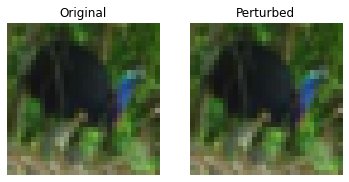

Real class: bird
Predicted class: deer with 56.0 confidence


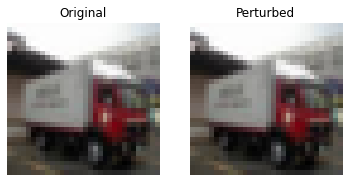

Real class: truck
Predicted class: truck with 70.0 confidence


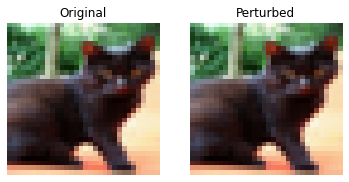

Real class: cat
Predicted class: cat with 27.0 confidence


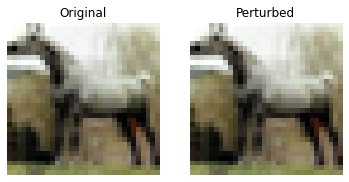

Real class: horse
Predicted class: horse with 69.0 confidence


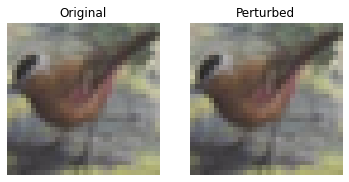

Real class: bird
Predicted class: frog with 27.0 confidence


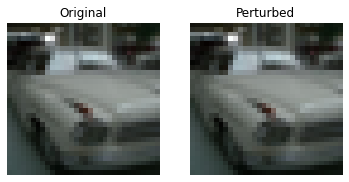

Real class: automobile
Predicted class: automobile with 50.0 confidence


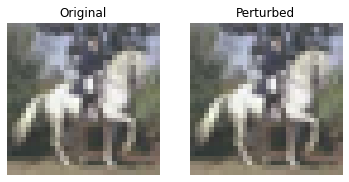

Real class: horse
Predicted class: horse with 68.0 confidence


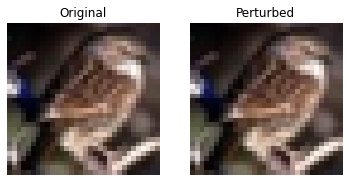

Real class: bird
Predicted class: frog with 47.0 confidence


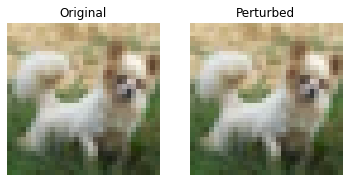

Real class: dog
Predicted class: dog with 29.0 confidence


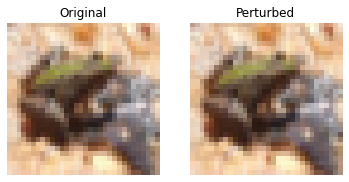

Real class: frog
Predicted class: frog with 61.0 confidence


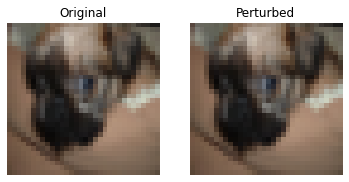

Real class: dog
Predicted class: dog with 21.0 confidence


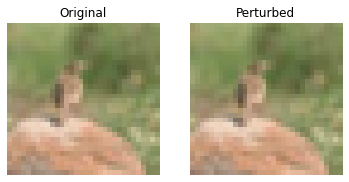

Real class: bird
Predicted class: deer with 46.0 confidence


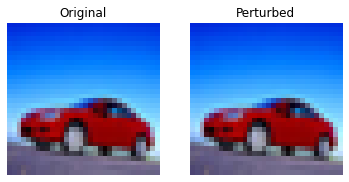

Real class: automobile
Predicted class: automobile with 73.0 confidence


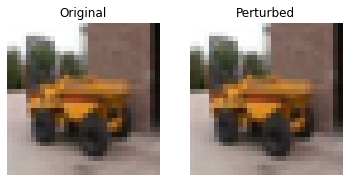

Real class: truck
Predicted class: truck with 75.0 confidence


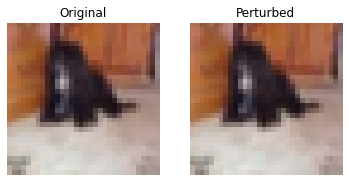

Real class: dog
Predicted class: cat with 41.0 confidence


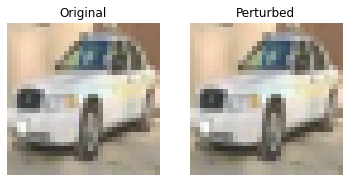

Real class: automobile
Predicted class: automobile with 91.0 confidence


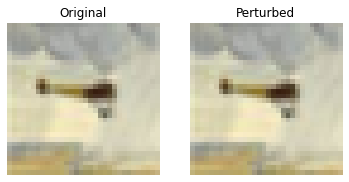

Real class: airplane
Predicted class: airplane with 53.0 confidence


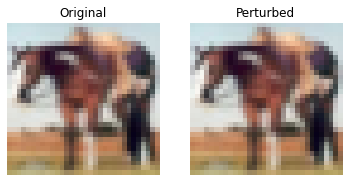

Real class: horse
Predicted class: horse with 82.0 confidence


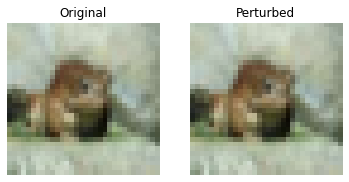

Real class: frog
Predicted class: frog with 29.0 confidence


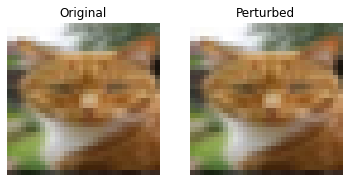

Real class: cat
Predicted class: cat with 22.0 confidence


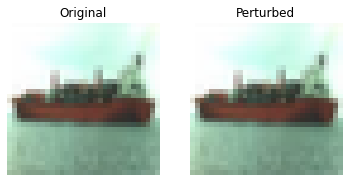

Real class: ship
Predicted class: ship with 87.0 confidence


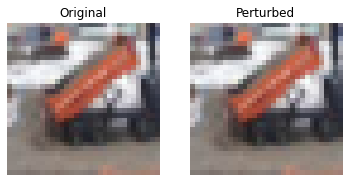

Real class: truck
Predicted class: truck with 46.0 confidence


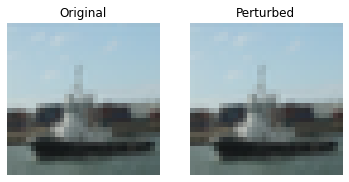

Real class: ship
Predicted class: ship with 72.0 confidence


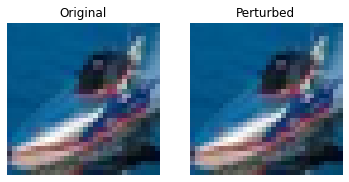

Real class: ship
Predicted class: ship with 63.0 confidence


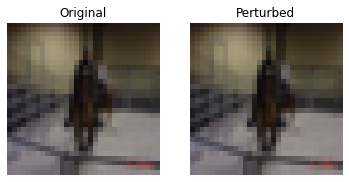

Real class: horse
Predicted class: deer with 36.0 confidence


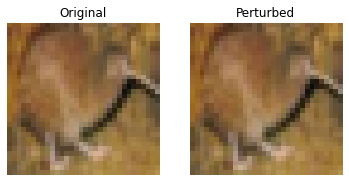

Real class: bird
Predicted class: frog with 62.0 confidence


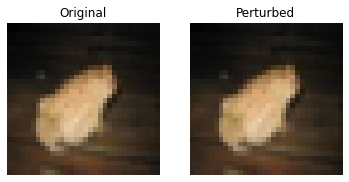

Real class: frog
Predicted class: frog with 71.0 confidence


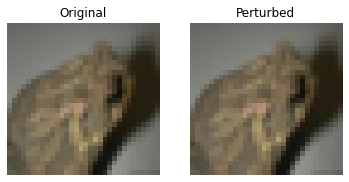

Real class: frog
Predicted class: frog with 48.0 confidence


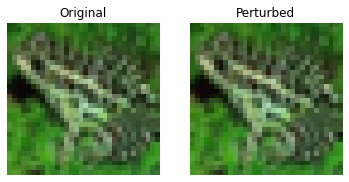

Real class: frog
Predicted class: frog with 58.0 confidence


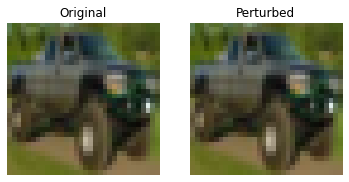

Real class: truck
Predicted class: deer with 42.0 confidence


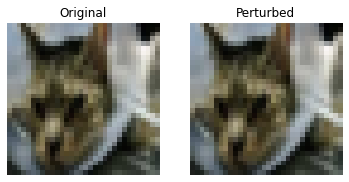

Real class: cat
Predicted class: cat with 27.0 confidence


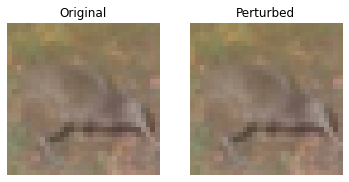

Real class: bird
Predicted class: bird with 35.0 confidence


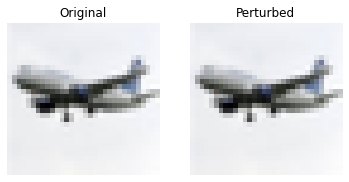

Real class: airplane
Predicted class: airplane with 99.0 confidence


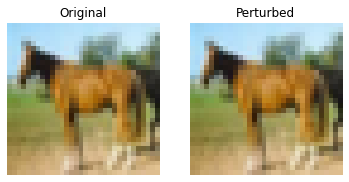

Real class: horse
Predicted class: horse with 98.0 confidence


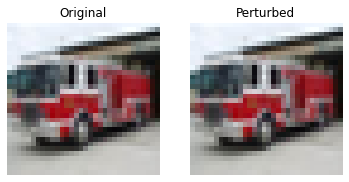

Real class: truck
Predicted class: truck with 95.0 confidence


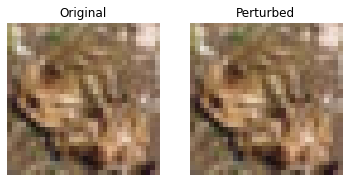

Real class: frog
Predicted class: frog with 68.0 confidence


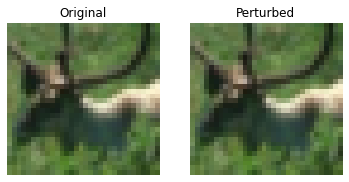

Real class: deer
Predicted class: deer with 36.0 confidence


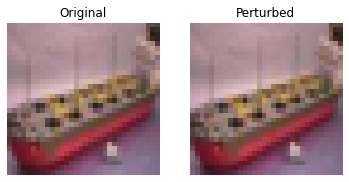

Real class: ship
Predicted class: ship with 54.0 confidence


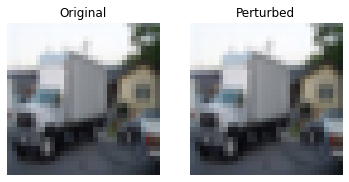

Real class: truck
Predicted class: truck with 76.0 confidence


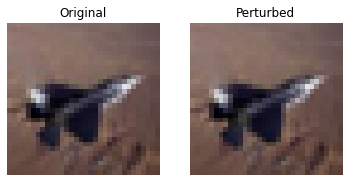

Real class: airplane
Predicted class: deer with 27.0 confidence


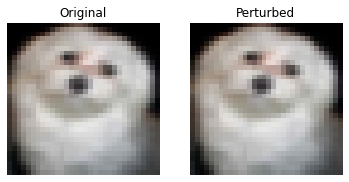

Real class: dog
Predicted class: dog with 80.0 confidence


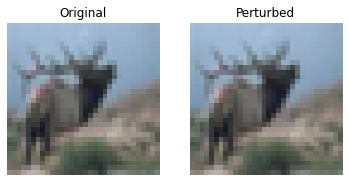

Real class: deer
Predicted class: bird with 23.0 confidence


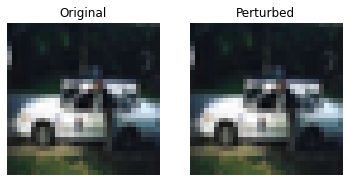

Real class: automobile
Predicted class: automobile with 73.0 confidence


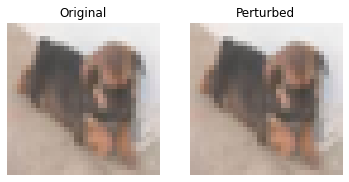

Real class: dog
Predicted class: frog with 45.0 confidence


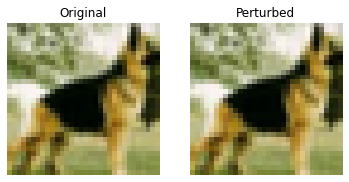

Real class: dog
Predicted class: horse with 36.0 confidence


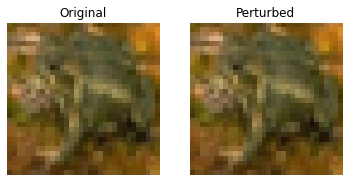

Real class: frog
Predicted class: frog with 55.0 confidence


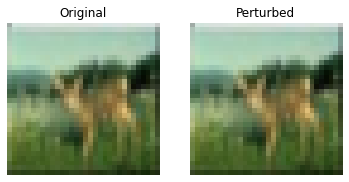

Real class: deer
Predicted class: horse with 32.0 confidence


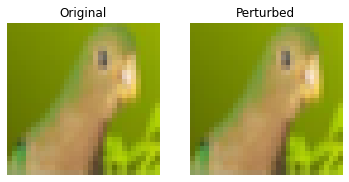

Real class: bird
Predicted class: bird with 37.0 confidence


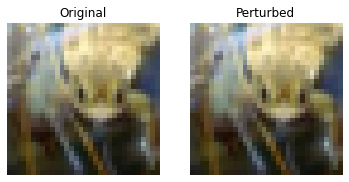

Real class: frog
Predicted class: frog with 28.0 confidence


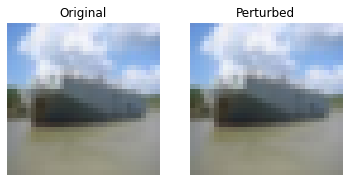

Real class: ship
Predicted class: ship with 73.0 confidence


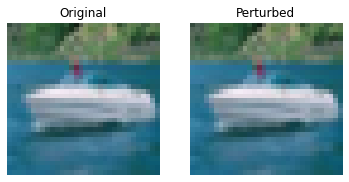

Real class: ship
Predicted class: ship with 71.0 confidence


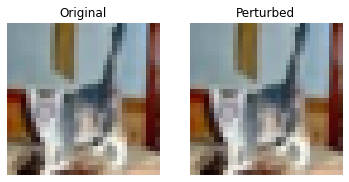

Real class: cat
Predicted class: cat with 36.0 confidence


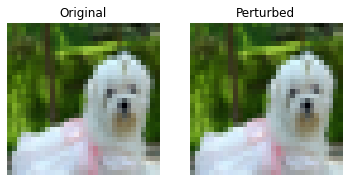

Real class: dog
Predicted class: dog with 54.0 confidence


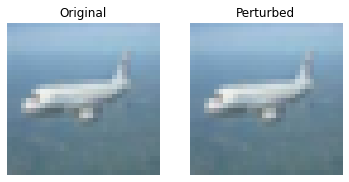

Real class: airplane
Predicted class: ship with 52.0 confidence


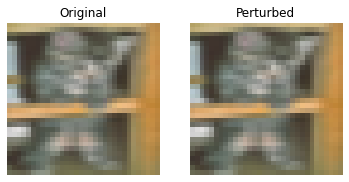

Real class: cat
Predicted class: bird with 20.0 confidence


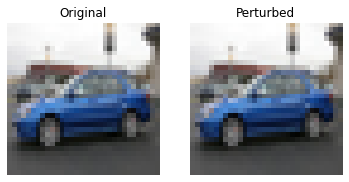

Real class: automobile
Predicted class: automobile with 76.0 confidence


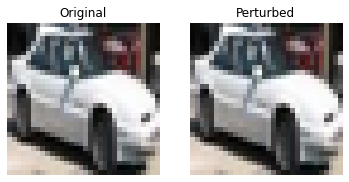

Real class: automobile
Predicted class: automobile with 90.0 confidence


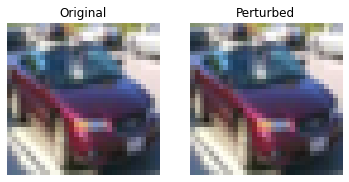

Real class: automobile
Predicted class: automobile with 55.0 confidence


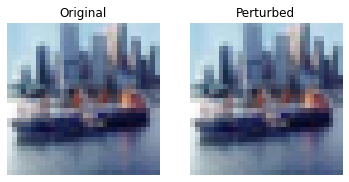

Real class: ship
Predicted class: truck with 36.0 confidence


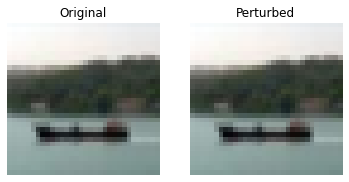

Real class: ship
Predicted class: ship with 61.0 confidence


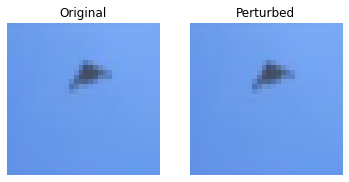

Real class: airplane
Predicted class: airplane with 69.0 confidence


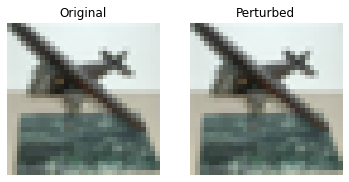

Real class: airplane
Predicted class: airplane with 42.0 confidence


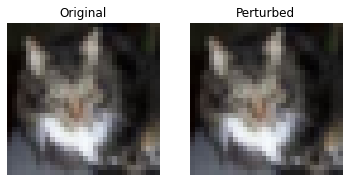

Real class: cat
Predicted class: cat with 44.0 confidence


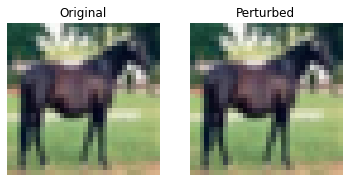

Real class: horse
Predicted class: horse with 98.0 confidence


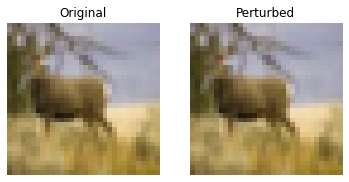

Real class: deer
Predicted class: deer with 36.0 confidence


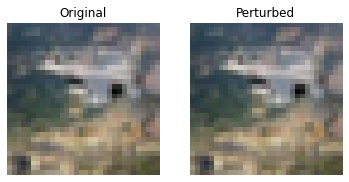

Real class: airplane
Predicted class: bird with 21.0 confidence


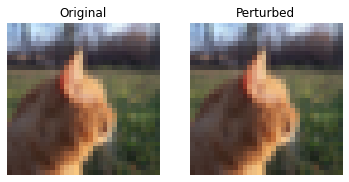

Real class: cat
Predicted class: horse with 34.0 confidence


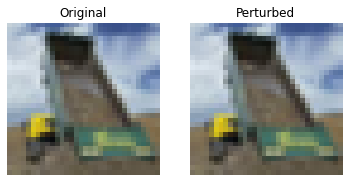

Real class: truck
Predicted class: truck with 32.0 confidence


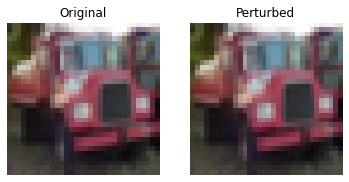

Real class: truck
Predicted class: truck with 52.0 confidence


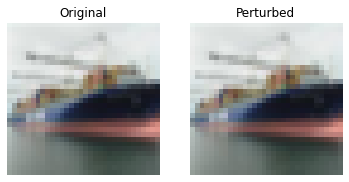

Real class: ship
Predicted class: ship with 82.0 confidence


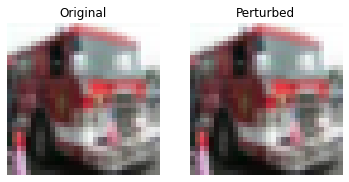

Real class: truck
Predicted class: truck with 83.0 confidence


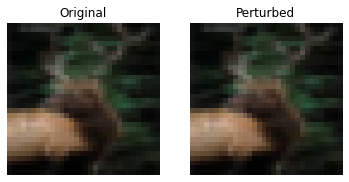

Real class: deer
Predicted class: deer with 38.0 confidence


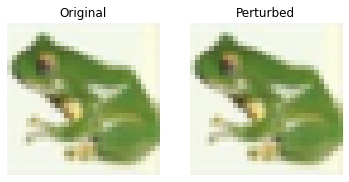

Real class: frog
Predicted class: frog with 83.0 confidence


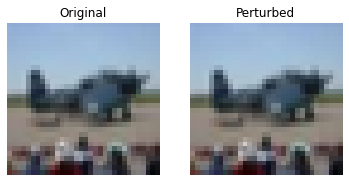

Real class: airplane
Predicted class: airplane with 45.0 confidence


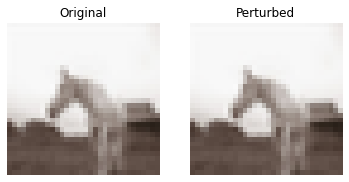

Real class: horse
Predicted class: ship with 56.0 confidence


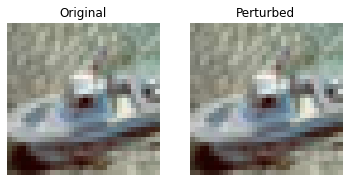

Real class: ship
Predicted class: ship with 44.0 confidence


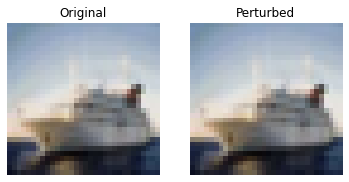

Real class: ship
Predicted class: ship with 74.0 confidence


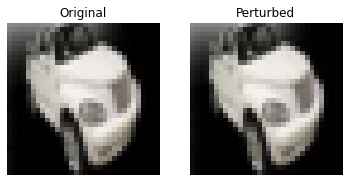

Real class: automobile
Predicted class: dog with 54.0 confidence


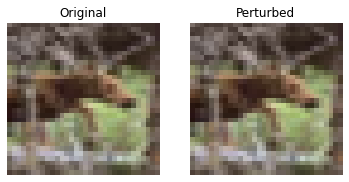

Real class: deer
Predicted class: deer with 33.0 confidence


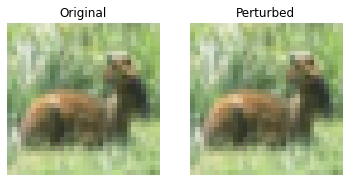

Real class: deer
Predicted class: frog with 40.0 confidence


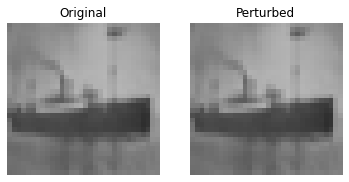

Real class: ship
Predicted class: ship with 82.0 confidence


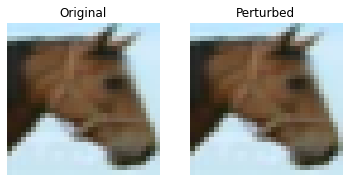

Real class: horse
Predicted class: cat with 30.0 confidence


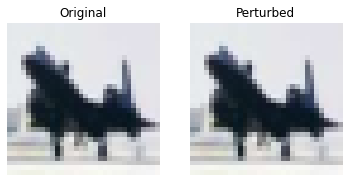

Real class: airplane
Predicted class: airplane with 53.0 confidence


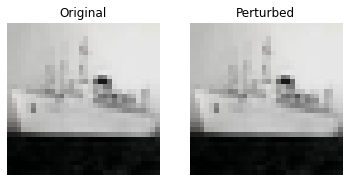

Real class: ship
Predicted class: ship with 59.0 confidence


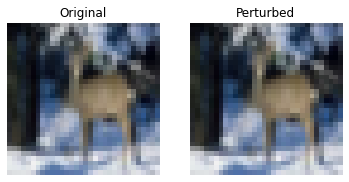

Real class: deer
Predicted class: cat with 28.0 confidence


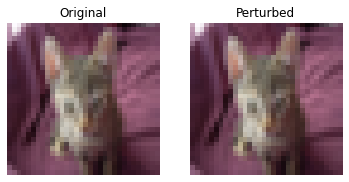

Real class: cat
Predicted class: dog with 24.0 confidence


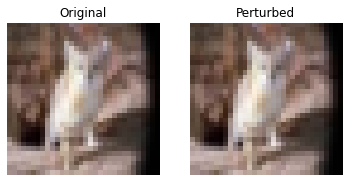

Real class: cat
Predicted class: dog with 37.0 confidence


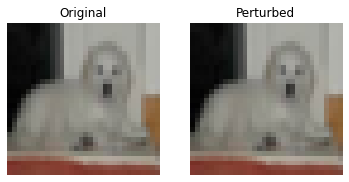

Real class: dog
Predicted class: dog with 33.0 confidence


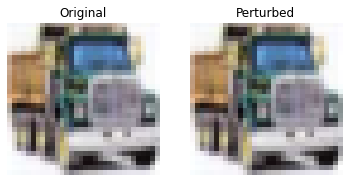

Real class: truck
Predicted class: truck with 76.0 confidence


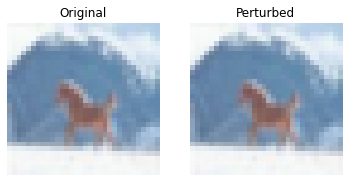

Real class: horse
Predicted class: airplane with 51.0 confidence


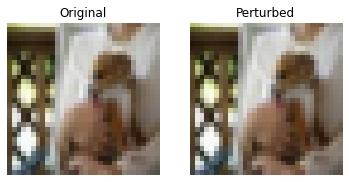

Real class: dog
Predicted class: dog with 30.0 confidence


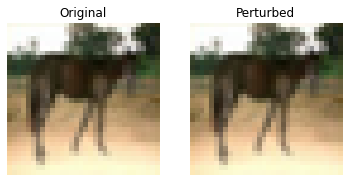

Real class: horse
Predicted class: horse with 85.0 confidence


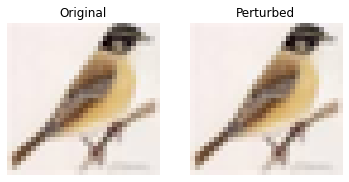

Real class: bird
Predicted class: bird with 63.0 confidence


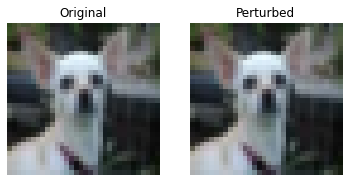

Real class: dog
Predicted class: dog with 44.0 confidence


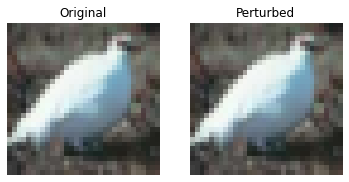

Real class: bird
Predicted class: automobile with 18.0 confidence


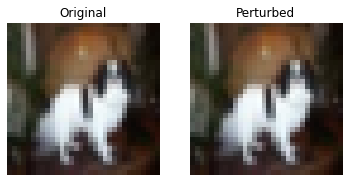

Real class: dog
Predicted class: dog with 53.0 confidence


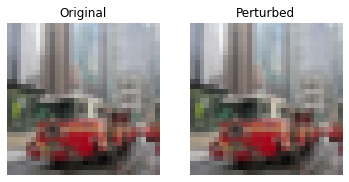

Real class: truck
Predicted class: truck with 38.0 confidence


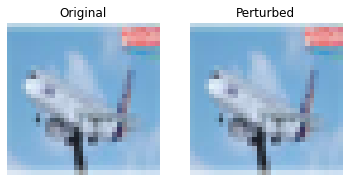

Real class: airplane
Predicted class: airplane with 81.0 confidence


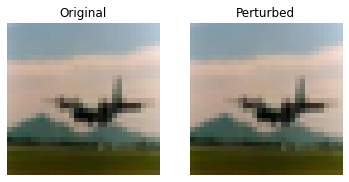

Real class: airplane
Predicted class: airplane with 53.0 confidence


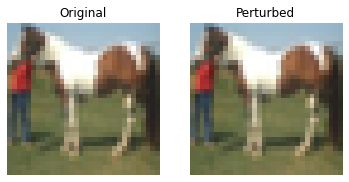

Real class: horse
Predicted class: horse with 72.0 confidence


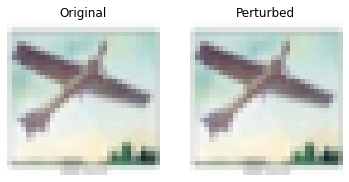

Real class: airplane
Predicted class: airplane with 77.0 confidence


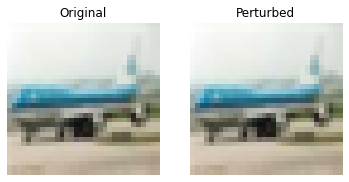

Real class: airplane
Predicted class: airplane with 88.0 confidence


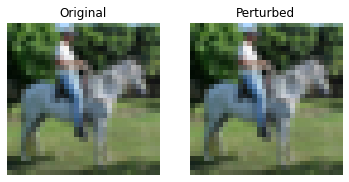

Real class: horse
Predicted class: horse with 60.0 confidence


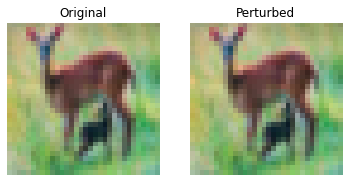

Real class: deer
Predicted class: deer with 32.0 confidence


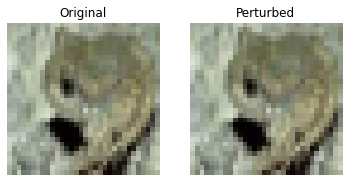

Real class: frog
Predicted class: frog with 59.0 confidence


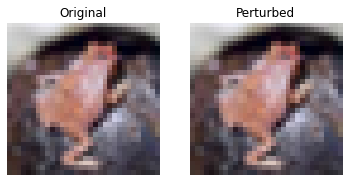

Real class: frog
Predicted class: frog with 33.0 confidence


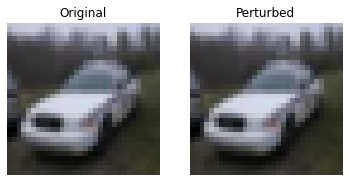

Real class: automobile
Predicted class: automobile with 86.0 confidence


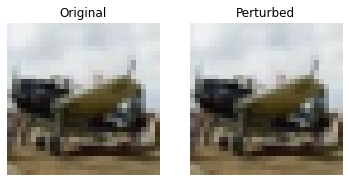

Real class: airplane
Predicted class: airplane with 35.0 confidence


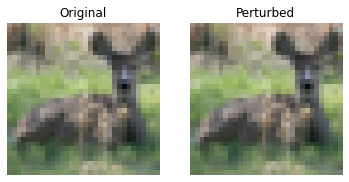

Real class: deer
Predicted class: deer with 27.0 confidence


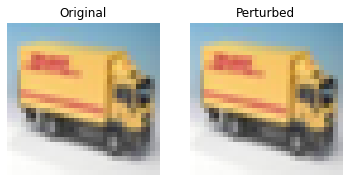

Real class: truck
Predicted class: truck with 79.0 confidence


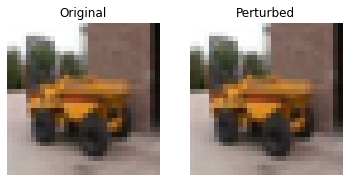

Real class: truck
Predicted class: truck with 75.0 confidence


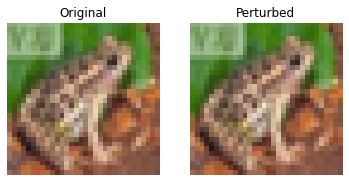

Real class: frog
Predicted class: frog with 76.0 confidence


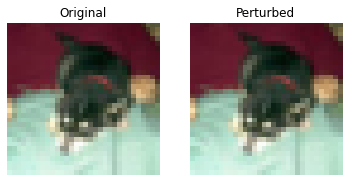

Real class: dog
Predicted class: cat with 36.0 confidence


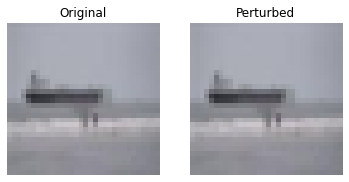

Real class: ship
Predicted class: ship with 52.0 confidence


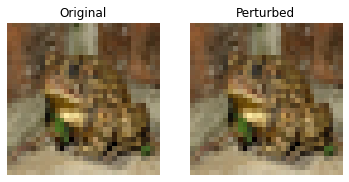

Real class: frog
Predicted class: frog with 57.0 confidence


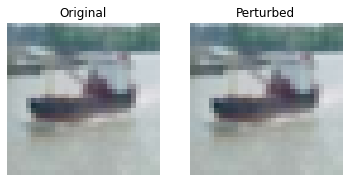

Real class: ship
Predicted class: airplane with 57.0 confidence


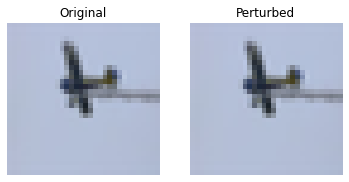

Real class: airplane
Predicted class: airplane with 74.0 confidence


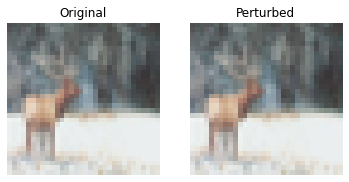

Real class: deer
Predicted class: deer with 35.0 confidence


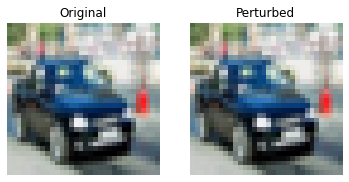

Real class: automobile
Predicted class: automobile with 66.0 confidence


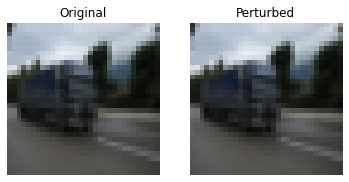

Real class: truck
Predicted class: truck with 42.0 confidence


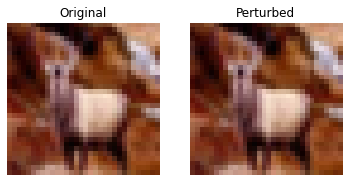

Real class: deer
Predicted class: horse with 25.0 confidence


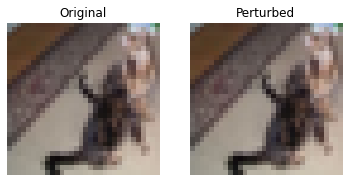

Real class: cat
Predicted class: frog with 28.0 confidence


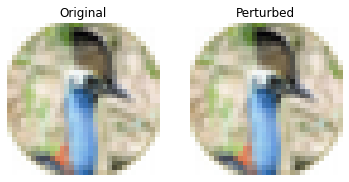

Real class: bird
Predicted class: bird with 31.0 confidence


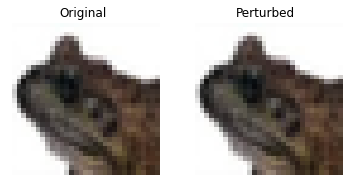

Real class: frog
Predicted class: frog with 30.0 confidence


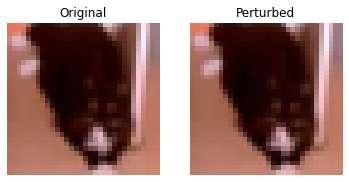

Real class: cat
Predicted class: dog with 40.0 confidence


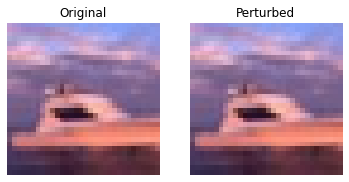

Real class: ship
Predicted class: ship with 94.0 confidence


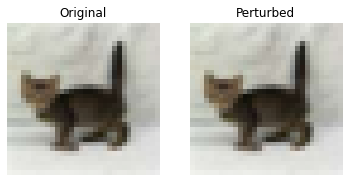

Real class: cat
Predicted class: cat with 27.0 confidence


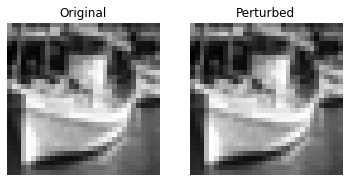

Real class: ship
Predicted class: ship with 42.0 confidence


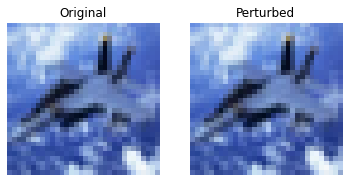

Real class: airplane
Predicted class: airplane with 65.0 confidence


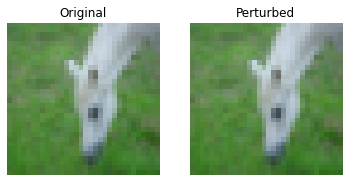

Real class: horse
Predicted class: dog with 36.0 confidence


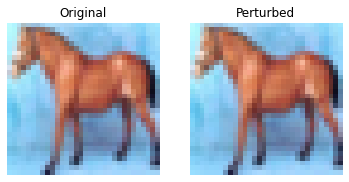

Real class: horse
Predicted class: horse with 58.0 confidence


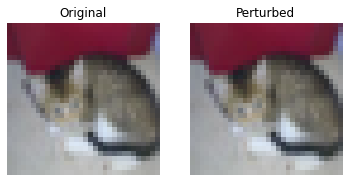

Real class: cat
Predicted class: cat with 32.0 confidence


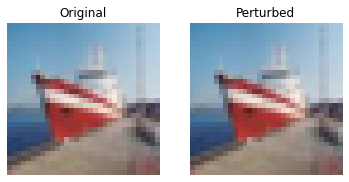

Real class: ship
Predicted class: ship with 76.0 confidence


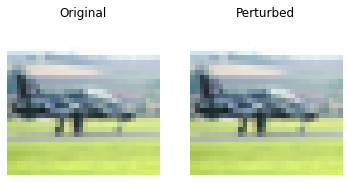

Real class: airplane
Predicted class: airplane with 89.0 confidence


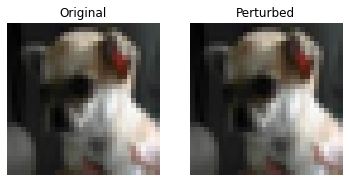

Real class: dog
Predicted class: dog with 50.0 confidence


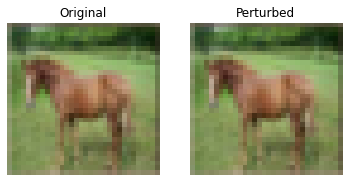

Real class: horse
Predicted class: horse with 45.0 confidence


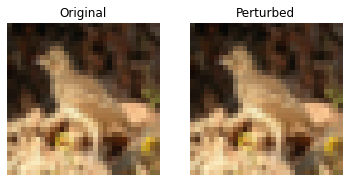

Real class: bird
Predicted class: frog with 42.0 confidence


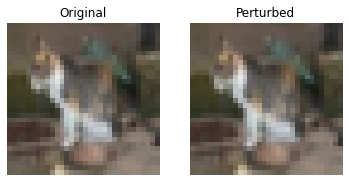

Real class: cat
Predicted class: frog with 21.0 confidence


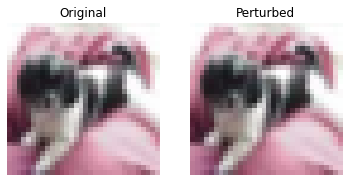

Real class: dog
Predicted class: dog with 31.0 confidence


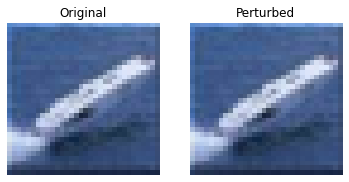

Real class: ship
Predicted class: ship with 54.0 confidence


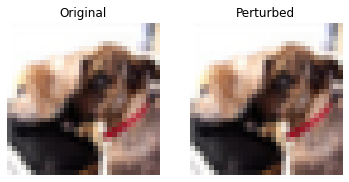

Real class: dog
Predicted class: truck with 31.0 confidence


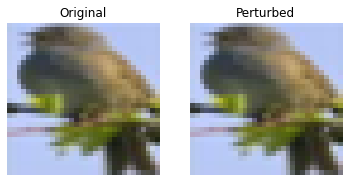

Real class: bird
Predicted class: frog with 27.0 confidence


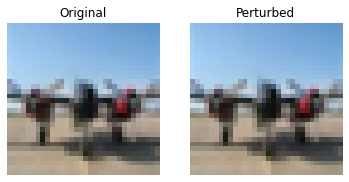

Real class: airplane
Predicted class: airplane with 70.0 confidence


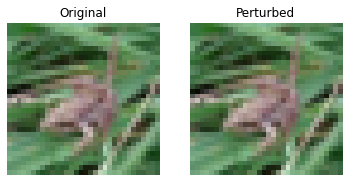

Real class: frog
Predicted class: frog with 60.0 confidence


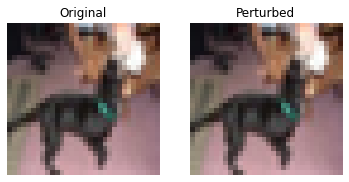

Real class: dog
Predicted class: horse with 46.0 confidence


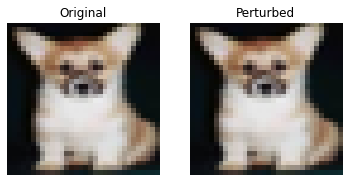

Real class: dog
Predicted class: dog with 68.0 confidence


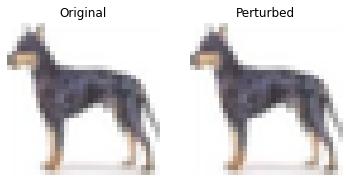

Real class: dog
Predicted class: horse with 78.0 confidence


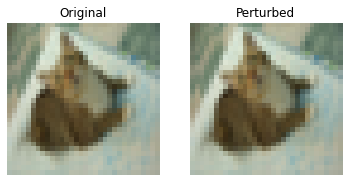

Real class: cat
Predicted class: frog with 52.0 confidence


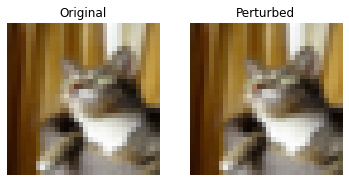

Real class: cat
Predicted class: dog with 40.0 confidence


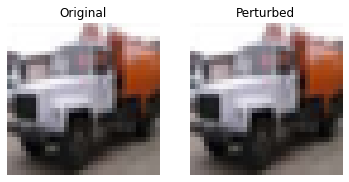

Real class: truck
Predicted class: truck with 73.0 confidence


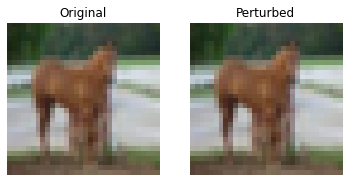

Real class: horse
Predicted class: horse with 65.0 confidence


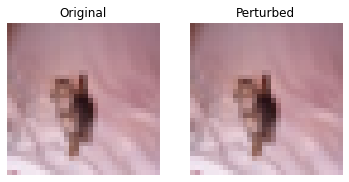

Real class: cat
Predicted class: bird with 36.0 confidence


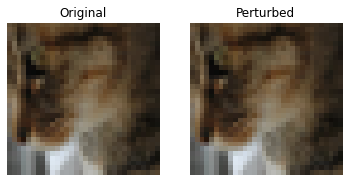

Real class: cat
Predicted class: frog with 25.0 confidence


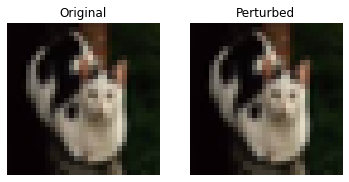

Real class: cat
Predicted class: cat with 36.0 confidence


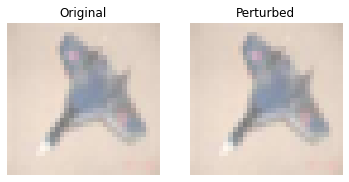

Real class: airplane
Predicted class: airplane with 28.0 confidence


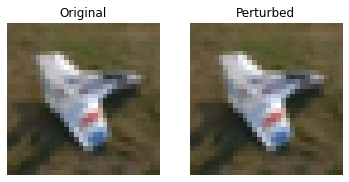

Real class: airplane
Predicted class: bird with 24.0 confidence


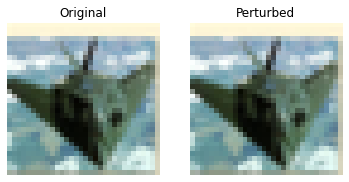

Real class: airplane
Predicted class: airplane with 56.0 confidence


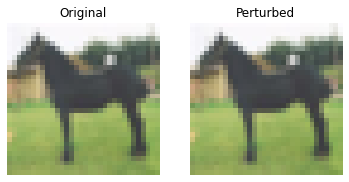

Real class: horse
Predicted class: horse with 99.0 confidence


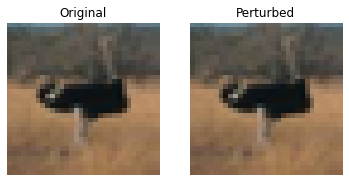

Real class: bird
Predicted class: deer with 35.0 confidence


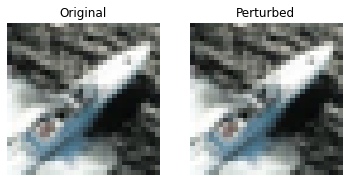

Real class: ship
Predicted class: ship with 25.0 confidence


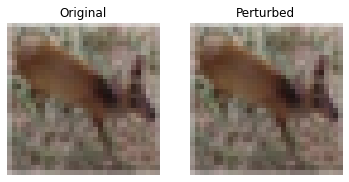

Real class: deer
Predicted class: horse with 41.0 confidence


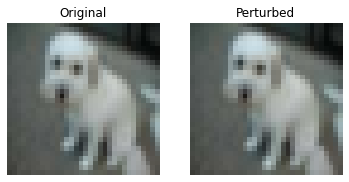

Real class: dog
Predicted class: dog with 53.0 confidence


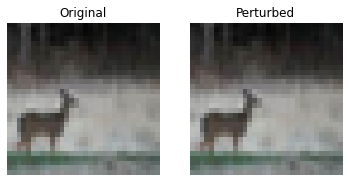

Real class: deer
Predicted class: deer with 61.0 confidence


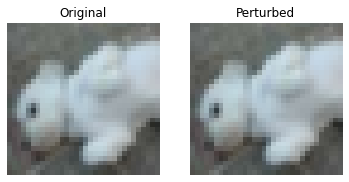

Real class: dog
Predicted class: ship with 29.0 confidence


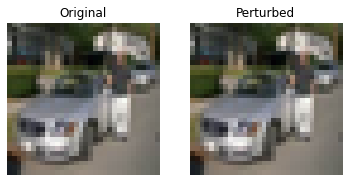

Real class: automobile
Predicted class: automobile with 29.0 confidence


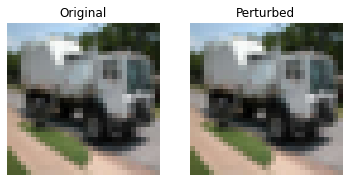

Real class: truck
Predicted class: automobile with 49.0 confidence


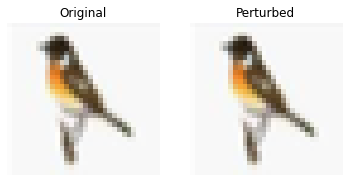

Real class: bird
Predicted class: bird with 65.0 confidence


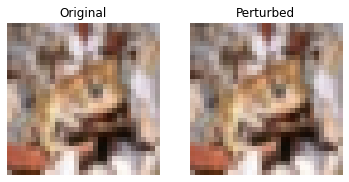

Real class: frog
Predicted class: frog with 41.0 confidence


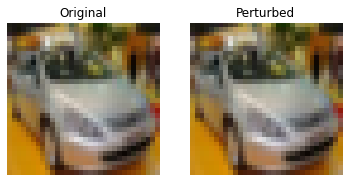

Real class: automobile
Predicted class: automobile with 52.0 confidence


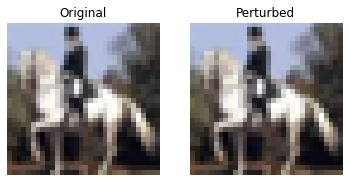

Real class: horse
Predicted class: horse with 56.0 confidence


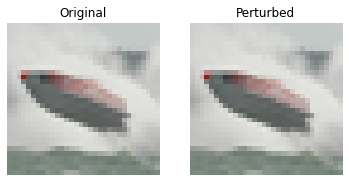

Real class: ship
Predicted class: airplane with 53.0 confidence


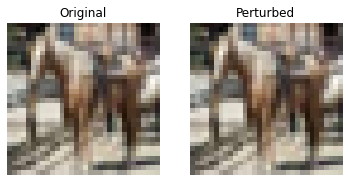

Real class: horse
Predicted class: horse with 80.0 confidence


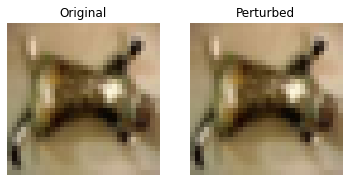

Real class: cat
Predicted class: deer with 25.0 confidence


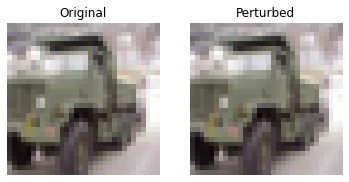

Real class: truck
Predicted class: truck with 39.0 confidence


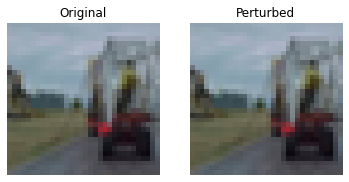

Real class: truck
Predicted class: ship with 37.0 confidence


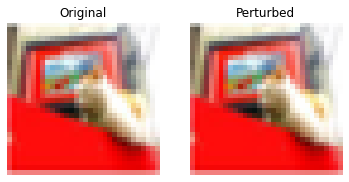

Real class: cat
Predicted class: airplane with 22.0 confidence


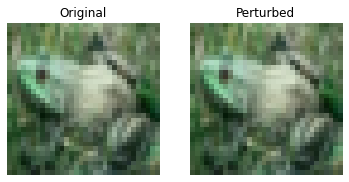

Real class: frog
Predicted class: frog with 58.0 confidence


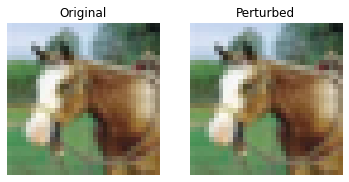

Real class: horse
Predicted class: horse with 39.0 confidence


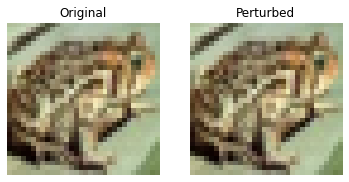

Real class: frog
Predicted class: frog with 86.0 confidence


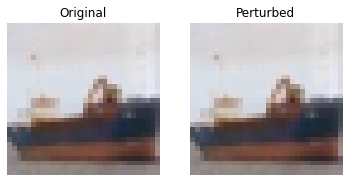

Real class: ship
Predicted class: ship with 69.0 confidence
Robustness ELU CNN original Accuracy 0.695%
Robustness ELU CNN 0.695%
time: 1min 27s


In [27]:
# Robustness Accuracy on test set for rob_elu_cnn model, set plot=True if you want image-wise stats
nfool = 0
nacc = 0
for perturbed_img in x_test_sample:
    
    original_idx = find_original_img(perturbed_img)
    nacc += attack_succeed(x_test[original_idx], original_idx, x_test[original_idx], rob_elu_cnn, plot=False) 
    nfool += attack_succeed(x_test[original_idx], original_idx, perturbed_img, rob_elu_cnn, plot=True) 

print("Robust ELU CNN original Accuracy {}%\nRobust ELU CNN Accuracy{}%".format(nacc/200, nfool/200))

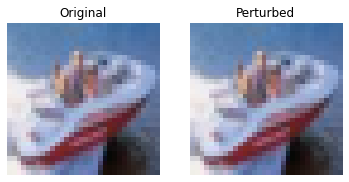

Real class: ship
Predicted class: ship with 90.0 confidence


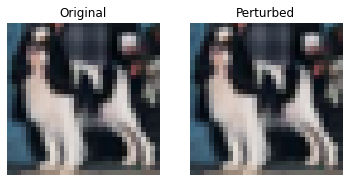

Real class: dog
Predicted class: dog with 51.0 confidence


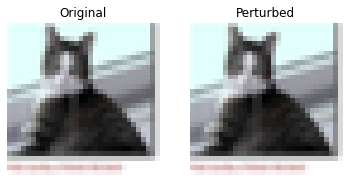

Real class: cat
Predicted class: cat with 25.0 confidence


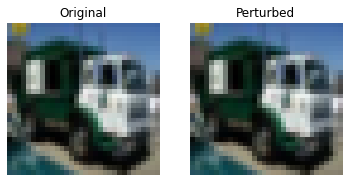

Real class: truck
Predicted class: truck with 85.0 confidence


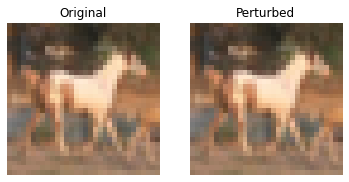

Real class: horse
Predicted class: horse with 73.0 confidence


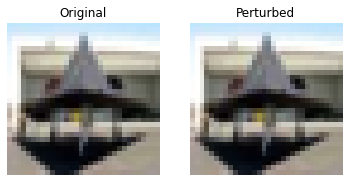

Real class: airplane
Predicted class: truck with 46.0 confidence


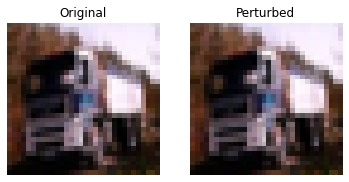

Real class: truck
Predicted class: truck with 84.0 confidence


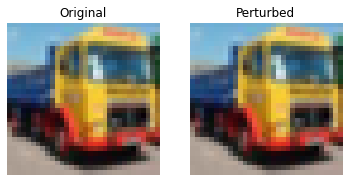

Real class: truck
Predicted class: truck with 83.0 confidence


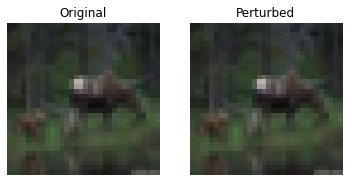

Real class: deer
Predicted class: deer with 40.0 confidence


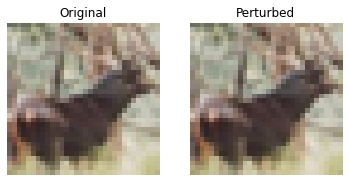

Real class: deer
Predicted class: frog with 50.0 confidence


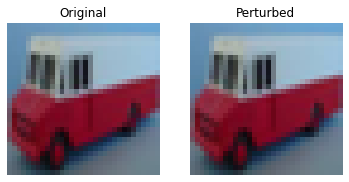

Real class: truck
Predicted class: automobile with 47.0 confidence


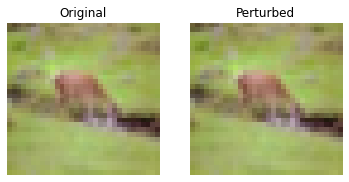

Real class: deer
Predicted class: deer with 46.0 confidence


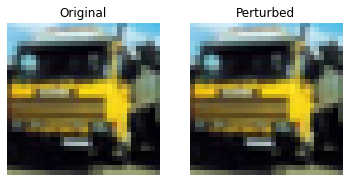

Real class: truck
Predicted class: truck with 65.0 confidence


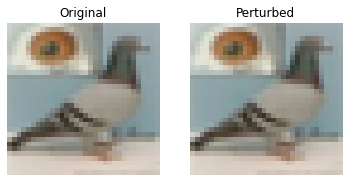

Real class: bird
Predicted class: bird with 25.0 confidence


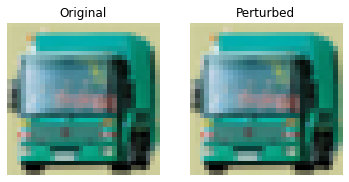

Real class: truck
Predicted class: truck with 66.0 confidence


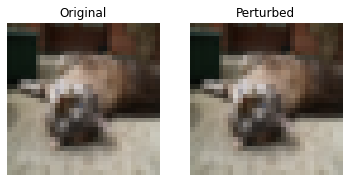

Real class: cat
Predicted class: deer with 23.0 confidence


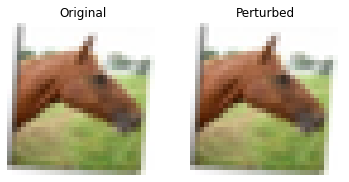

Real class: horse
Predicted class: horse with 81.0 confidence


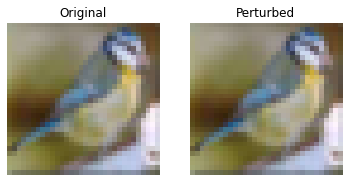

Real class: bird
Predicted class: frog with 27.0 confidence


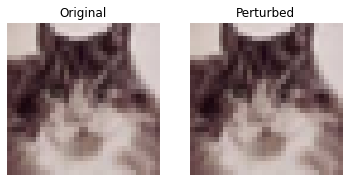

Real class: cat
Predicted class: cat with 39.0 confidence


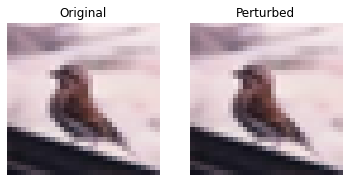

Real class: bird
Predicted class: ship with 46.0 confidence


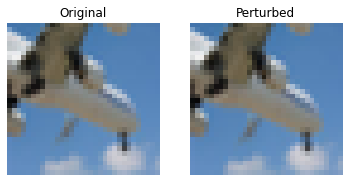

Real class: airplane
Predicted class: airplane with 27.0 confidence


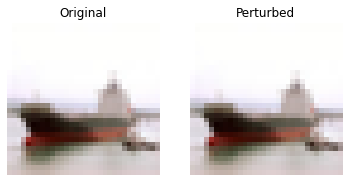

Real class: ship
Predicted class: ship with 88.0 confidence


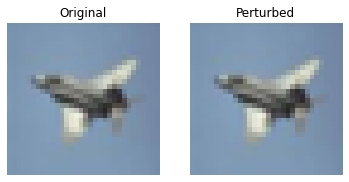

Real class: airplane
Predicted class: airplane with 90.0 confidence


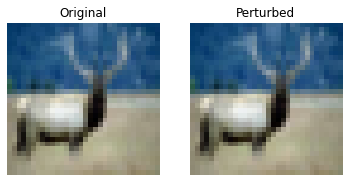

Real class: deer
Predicted class: deer with 62.0 confidence


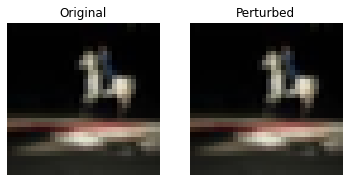

Real class: horse
Predicted class: airplane with 21.0 confidence


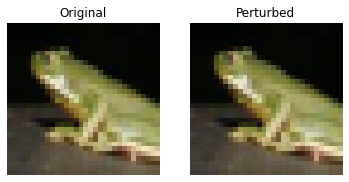

Real class: frog
Predicted class: frog with 78.0 confidence


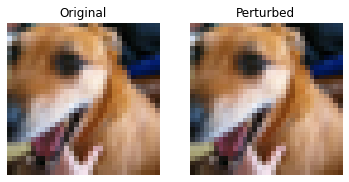

Real class: dog
Predicted class: dog with 39.0 confidence


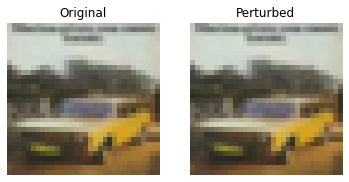

Real class: automobile
Predicted class: ship with 34.0 confidence


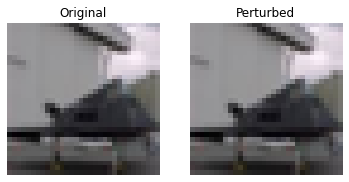

Real class: airplane
Predicted class: airplane with 28.0 confidence


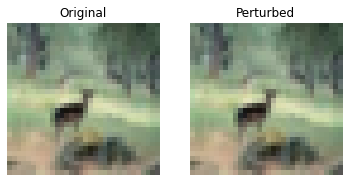

Real class: deer
Predicted class: deer with 44.0 confidence


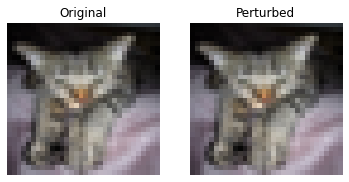

Real class: cat
Predicted class: frog with 29.0 confidence


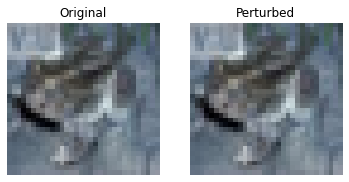

Real class: frog
Predicted class: frog with 31.0 confidence


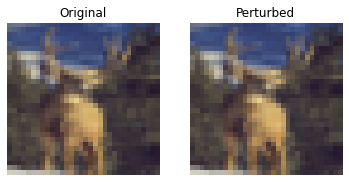

Real class: deer
Predicted class: deer with 25.0 confidence


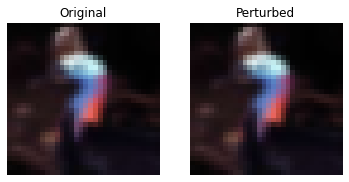

Real class: bird
Predicted class: bird with 52.0 confidence


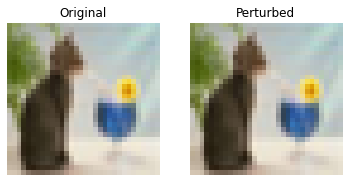

Real class: cat
Predicted class: dog with 34.0 confidence


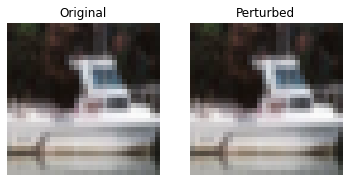

Real class: ship
Predicted class: ship with 71.0 confidence


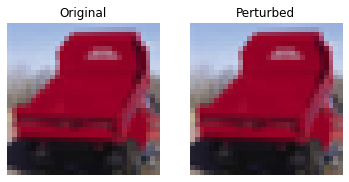

Real class: truck
Predicted class: truck with 84.0 confidence


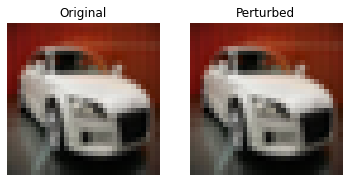

Real class: automobile
Predicted class: automobile with 96.0 confidence


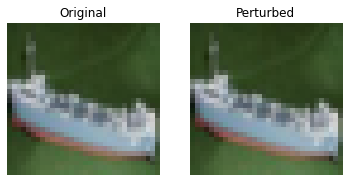

Real class: ship
Predicted class: ship with 73.0 confidence


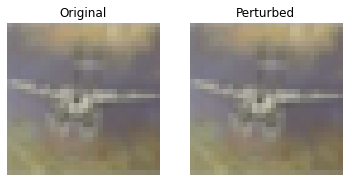

Real class: airplane
Predicted class: deer with 26.0 confidence


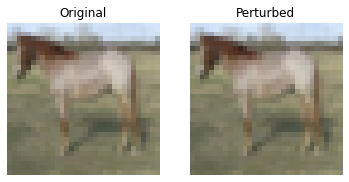

Real class: horse
Predicted class: horse with 60.0 confidence


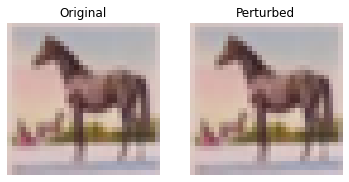

Real class: horse
Predicted class: horse with 92.0 confidence


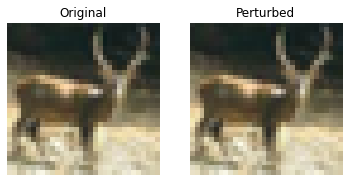

Real class: deer
Predicted class: horse with 57.0 confidence


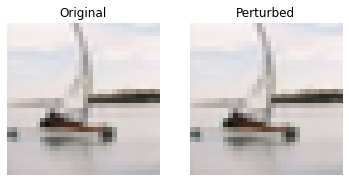

Real class: ship
Predicted class: ship with 57.0 confidence


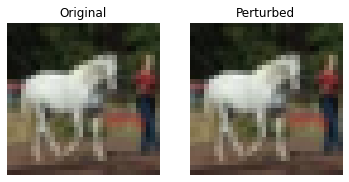

Real class: horse
Predicted class: horse with 91.0 confidence


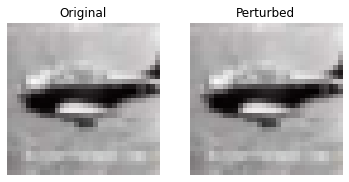

Real class: airplane
Predicted class: airplane with 83.0 confidence


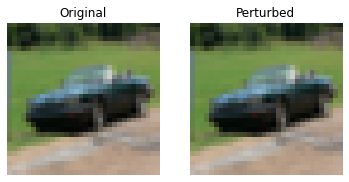

Real class: automobile
Predicted class: automobile with 74.0 confidence


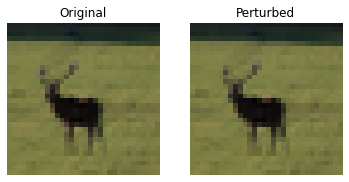

Real class: deer
Predicted class: deer with 58.0 confidence


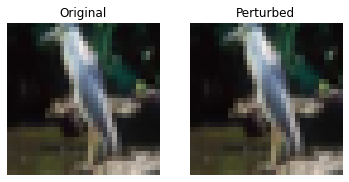

Real class: bird
Predicted class: bird with 34.0 confidence


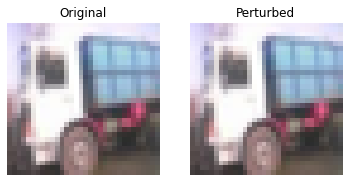

Real class: truck
Predicted class: truck with 75.0 confidence


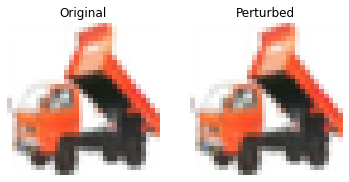

Real class: truck
Predicted class: truck with 90.0 confidence


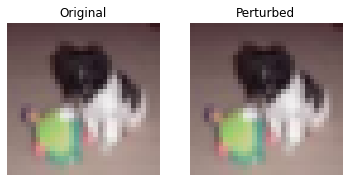

Real class: dog
Predicted class: dog with 51.0 confidence


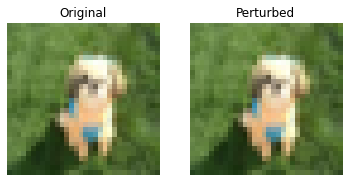

Real class: dog
Predicted class: dog with 55.0 confidence


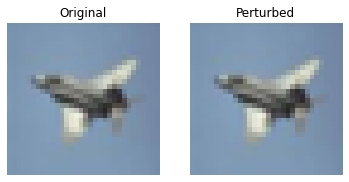

Real class: airplane
Predicted class: airplane with 90.0 confidence


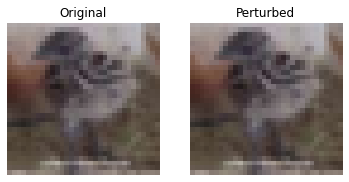

Real class: bird
Predicted class: frog with 29.0 confidence


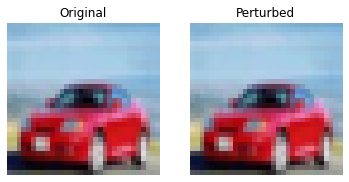

Real class: automobile
Predicted class: automobile with 91.0 confidence


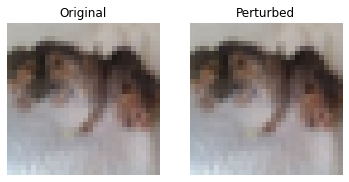

Real class: cat
Predicted class: cat with 30.0 confidence


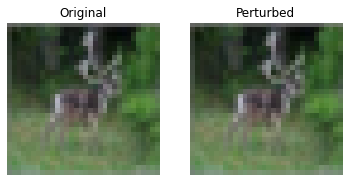

Real class: deer
Predicted class: deer with 66.0 confidence


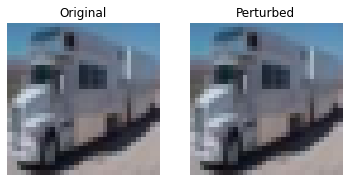

Real class: truck
Predicted class: truck with 73.0 confidence


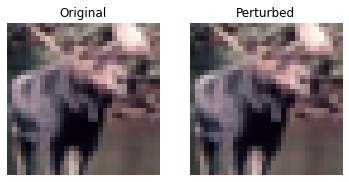

Real class: deer
Predicted class: frog with 21.0 confidence


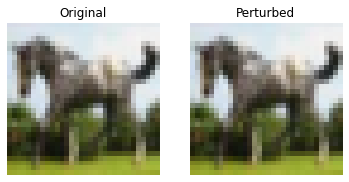

Real class: horse
Predicted class: horse with 56.0 confidence


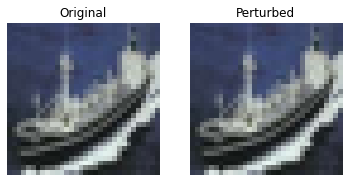

Real class: ship
Predicted class: ship with 93.0 confidence


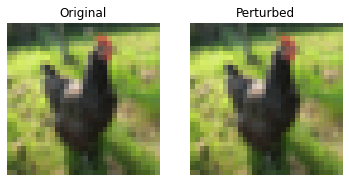

Real class: bird
Predicted class: bird with 31.0 confidence


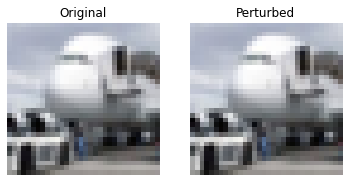

Real class: airplane
Predicted class: truck with 64.0 confidence


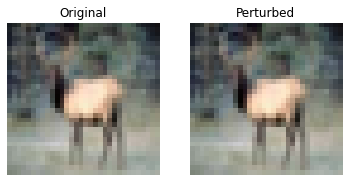

Real class: deer
Predicted class: deer with 50.0 confidence


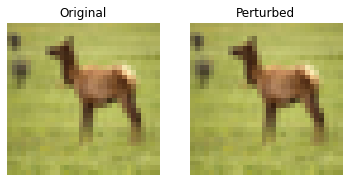

Real class: deer
Predicted class: deer with 49.0 confidence


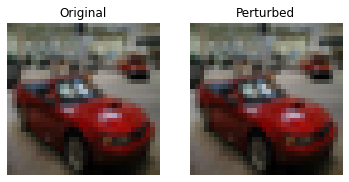

Real class: automobile
Predicted class: automobile with 81.0 confidence


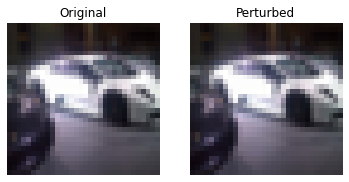

Real class: automobile
Predicted class: automobile with 40.0 confidence


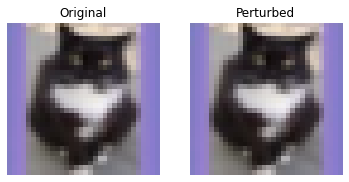

Real class: cat
Predicted class: automobile with 45.0 confidence


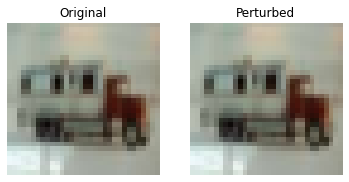

Real class: truck
Predicted class: truck with 41.0 confidence


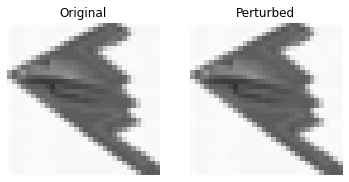

Real class: airplane
Predicted class: airplane with 52.0 confidence


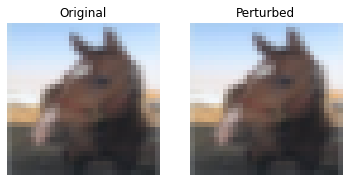

Real class: horse
Predicted class: horse with 36.0 confidence


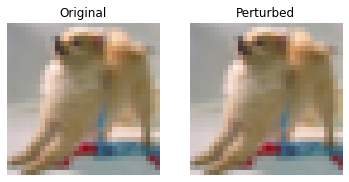

Real class: dog
Predicted class: cat with 24.0 confidence


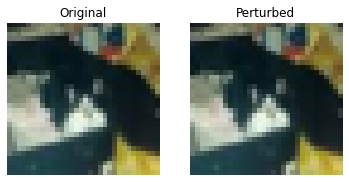

Real class: cat
Predicted class: cat with 23.0 confidence


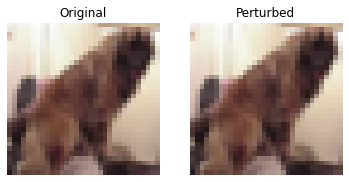

Real class: dog
Predicted class: frog with 38.0 confidence


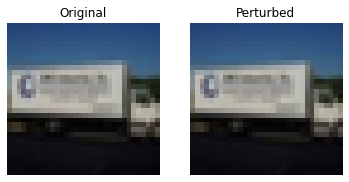

Real class: truck
Predicted class: truck with 40.0 confidence


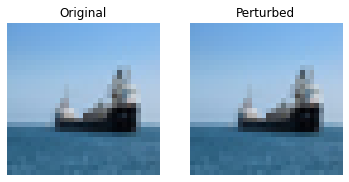

Real class: ship
Predicted class: ship with 95.0 confidence


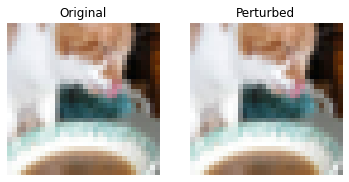

Real class: cat
Predicted class: cat with 30.0 confidence


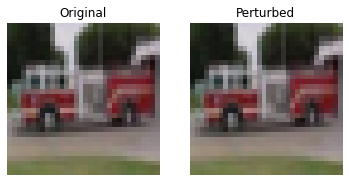

Real class: truck
Predicted class: truck with 62.0 confidence


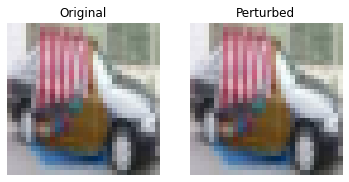

Real class: automobile
Predicted class: automobile with 45.0 confidence


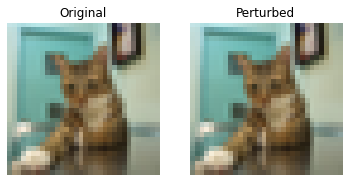

Real class: cat
Predicted class: cat with 22.0 confidence


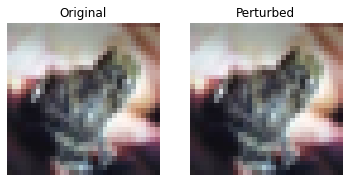

Real class: frog
Predicted class: cat with 21.0 confidence


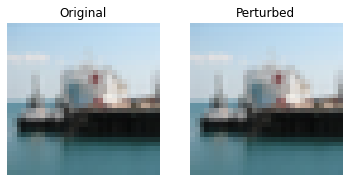

Real class: ship
Predicted class: ship with 94.0 confidence


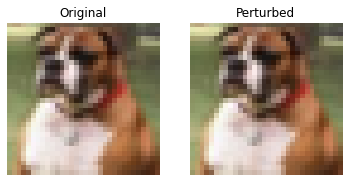

Real class: dog
Predicted class: dog with 55.0 confidence


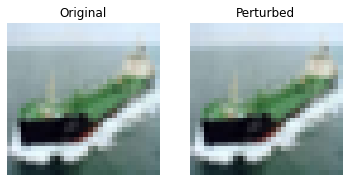

Real class: ship
Predicted class: ship with 86.0 confidence


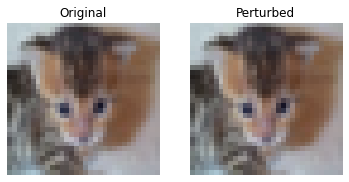

Real class: cat
Predicted class: frog with 32.0 confidence


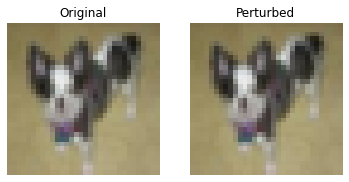

Real class: dog
Predicted class: dog with 25.0 confidence


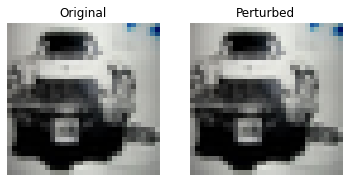

Real class: automobile
Predicted class: truck with 69.0 confidence


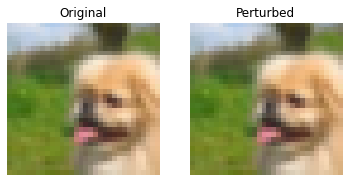

Real class: dog
Predicted class: horse with 18.0 confidence


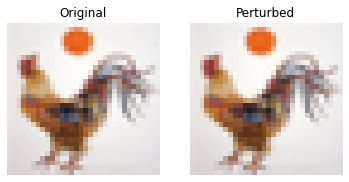

Real class: bird
Predicted class: airplane with 31.0 confidence


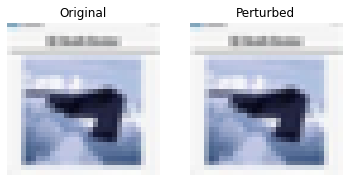

Real class: airplane
Predicted class: airplane with 62.0 confidence


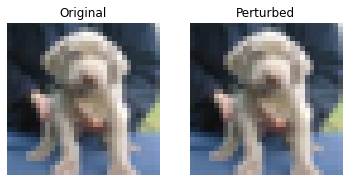

Real class: dog
Predicted class: dog with 63.0 confidence


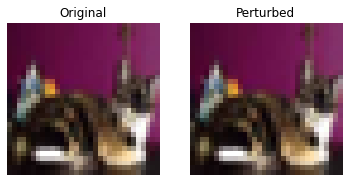

Real class: cat
Predicted class: cat with 26.0 confidence


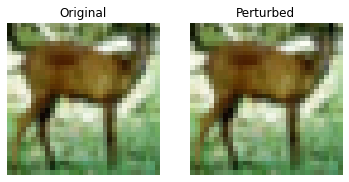

Real class: deer
Predicted class: horse with 80.0 confidence


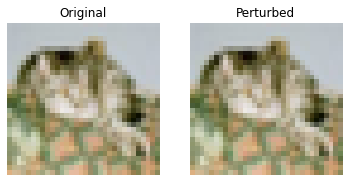

Real class: cat
Predicted class: frog with 39.0 confidence


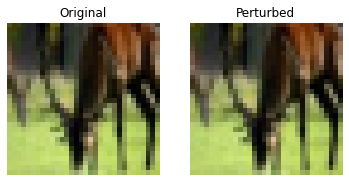

Real class: deer
Predicted class: horse with 48.0 confidence


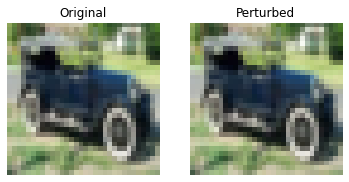

Real class: automobile
Predicted class: automobile with 24.0 confidence


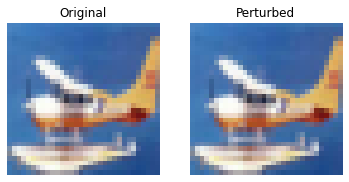

Real class: airplane
Predicted class: airplane with 49.0 confidence


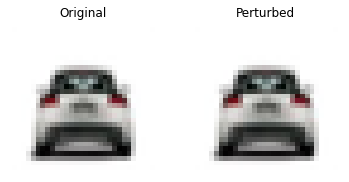

Real class: automobile
Predicted class: automobile with 92.0 confidence


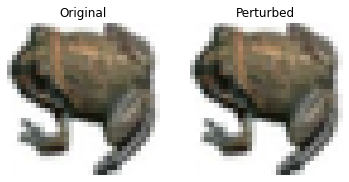

Real class: frog
Predicted class: frog with 68.0 confidence


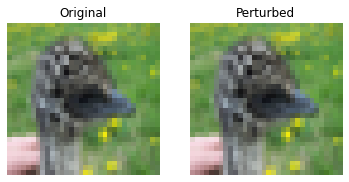

Real class: bird
Predicted class: deer with 36.0 confidence


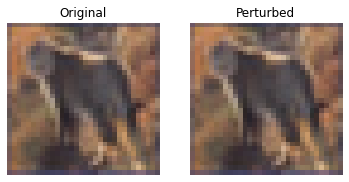

Real class: cat
Predicted class: frog with 30.0 confidence


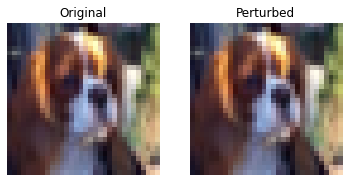

Real class: dog
Predicted class: dog with 50.0 confidence


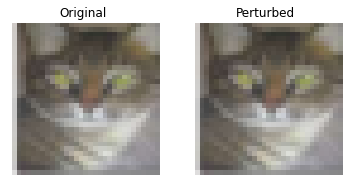

Real class: cat
Predicted class: cat with 35.0 confidence


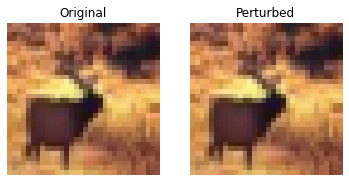

Real class: deer
Predicted class: deer with 55.0 confidence


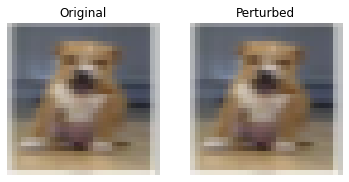

Real class: dog
Predicted class: frog with 33.0 confidence


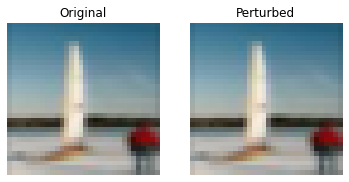

Real class: ship
Predicted class: ship with 57.0 confidence


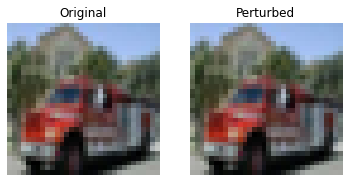

Real class: truck
Predicted class: truck with 88.0 confidence


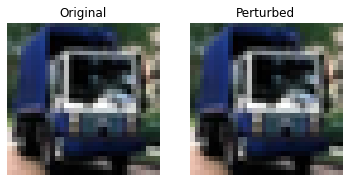

Real class: truck
Predicted class: automobile with 56.0 confidence


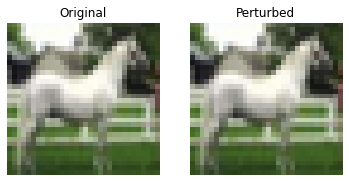

Real class: horse
Predicted class: horse with 95.0 confidence


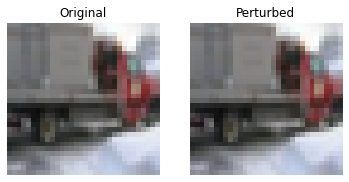

Real class: truck
Predicted class: truck with 78.0 confidence


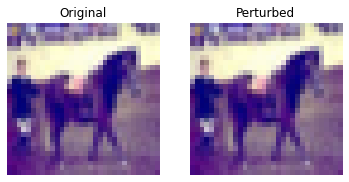

Real class: horse
Predicted class: horse with 48.0 confidence


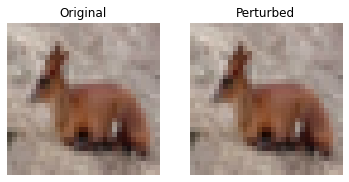

Real class: deer
Predicted class: frog with 34.0 confidence


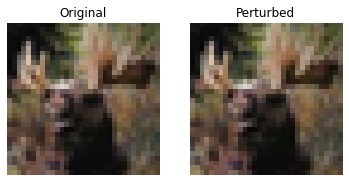

Real class: deer
Predicted class: frog with 31.0 confidence


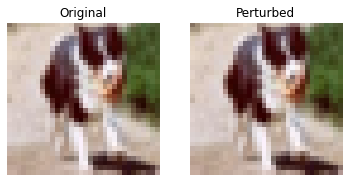

Real class: dog
Predicted class: dog with 42.0 confidence


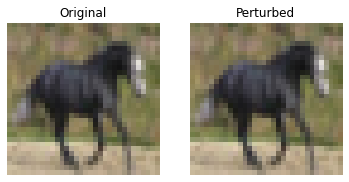

Real class: horse
Predicted class: horse with 77.0 confidence


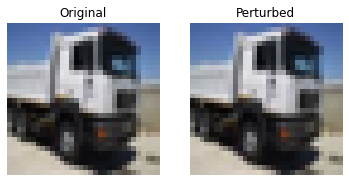

Real class: truck
Predicted class: truck with 81.0 confidence


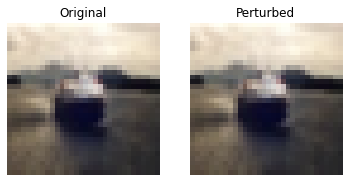

Real class: ship
Predicted class: ship with 37.0 confidence


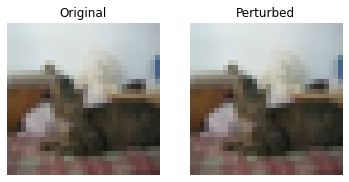

Real class: cat
Predicted class: airplane with 26.0 confidence


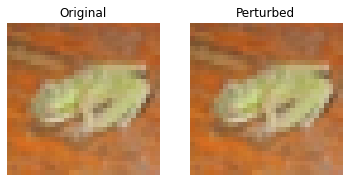

Real class: frog
Predicted class: frog with 38.0 confidence


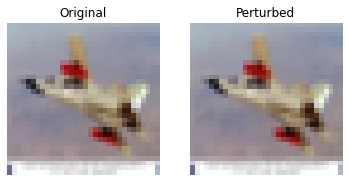

Real class: airplane
Predicted class: airplane with 28.0 confidence


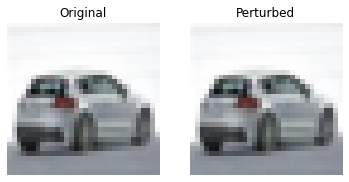

Real class: automobile
Predicted class: automobile with 95.0 confidence


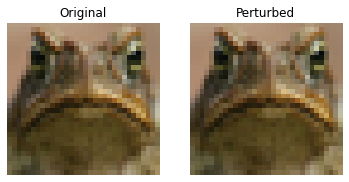

Real class: frog
Predicted class: frog with 47.0 confidence


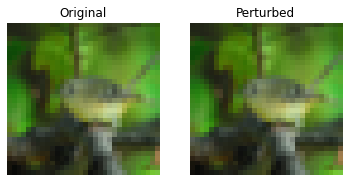

Real class: bird
Predicted class: frog with 38.0 confidence


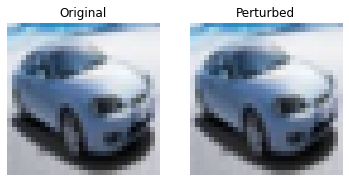

Real class: automobile
Predicted class: automobile with 72.0 confidence


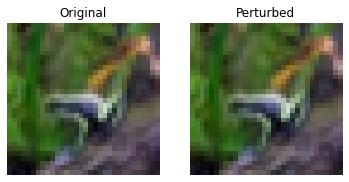

Real class: frog
Predicted class: frog with 41.0 confidence


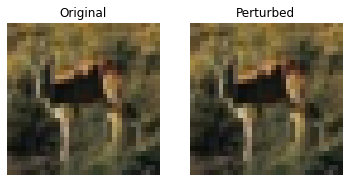

Real class: deer
Predicted class: frog with 33.0 confidence


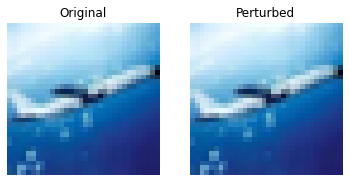

Real class: airplane
Predicted class: ship with 65.0 confidence


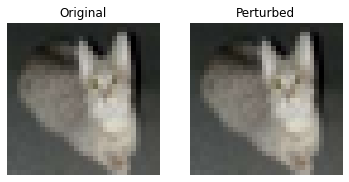

Real class: cat
Predicted class: dog with 47.0 confidence


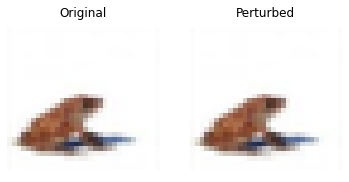

Real class: frog
Predicted class: airplane with 40.0 confidence


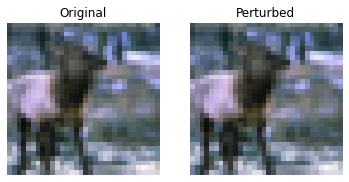

Real class: deer
Predicted class: horse with 25.0 confidence


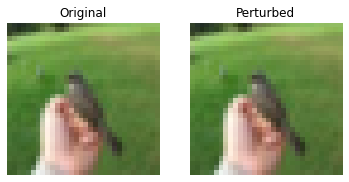

Real class: bird
Predicted class: bird with 42.0 confidence


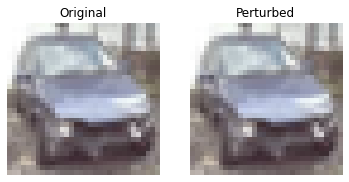

Real class: automobile
Predicted class: automobile with 45.0 confidence


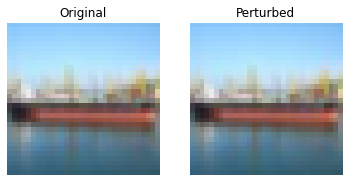

Real class: ship
Predicted class: ship with 90.0 confidence


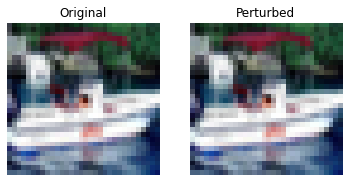

Real class: ship
Predicted class: ship with 96.0 confidence


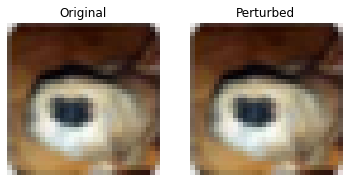

Real class: dog
Predicted class: dog with 47.0 confidence


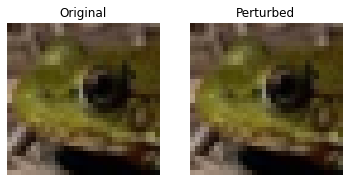

Real class: frog
Predicted class: frog with 44.0 confidence


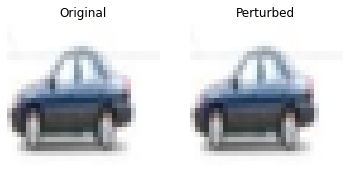

Real class: automobile
Predicted class: automobile with 66.0 confidence


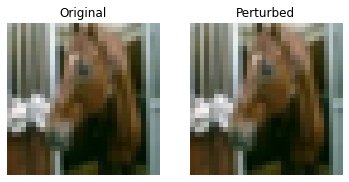

Real class: horse
Predicted class: horse with 27.0 confidence


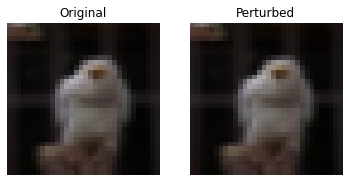

Real class: bird
Predicted class: frog with 29.0 confidence


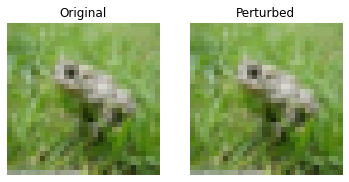

Real class: frog
Predicted class: deer with 36.0 confidence


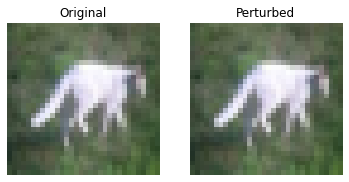

Real class: cat
Predicted class: horse with 35.0 confidence


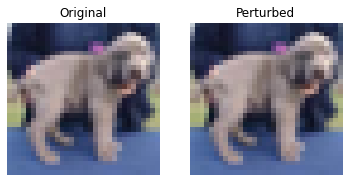

Real class: dog
Predicted class: dog with 34.0 confidence


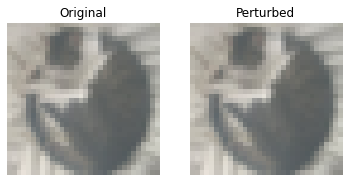

Real class: cat
Predicted class: cat with 25.0 confidence


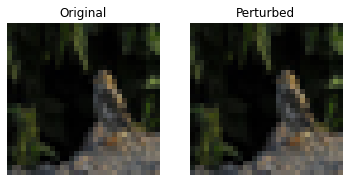

Real class: bird
Predicted class: deer with 34.0 confidence


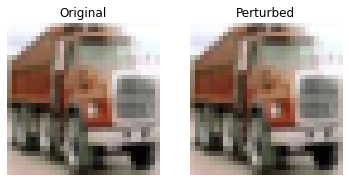

Real class: truck
Predicted class: truck with 93.0 confidence


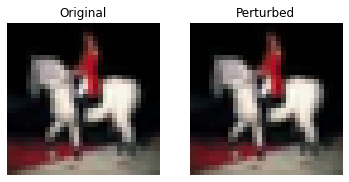

Real class: horse
Predicted class: horse with 87.0 confidence


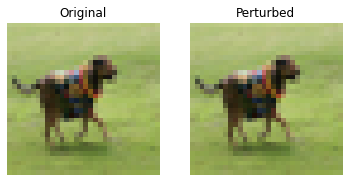

Real class: dog
Predicted class: deer with 54.0 confidence


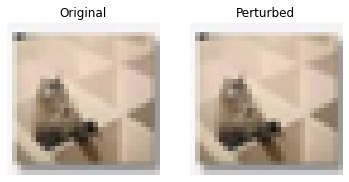

Real class: cat
Predicted class: frog with 21.0 confidence


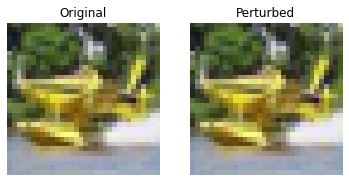

Real class: airplane
Predicted class: frog with 23.0 confidence


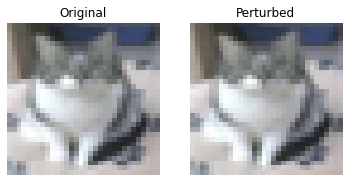

Real class: cat
Predicted class: cat with 23.0 confidence


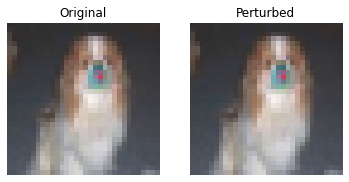

Real class: dog
Predicted class: dog with 56.0 confidence


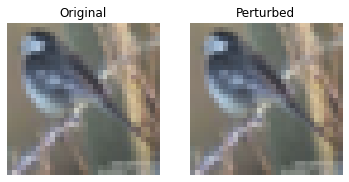

Real class: bird
Predicted class: bird with 27.0 confidence


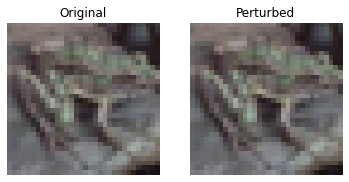

Real class: frog
Predicted class: frog with 46.0 confidence


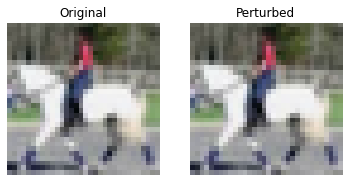

Real class: horse
Predicted class: horse with 54.0 confidence


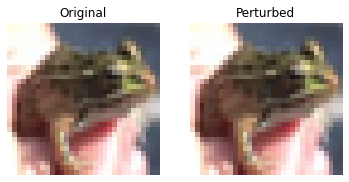

Real class: frog
Predicted class: frog with 57.0 confidence


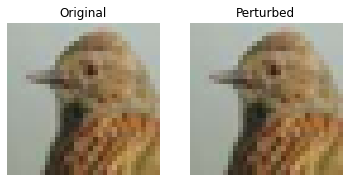

Real class: bird
Predicted class: bird with 31.0 confidence


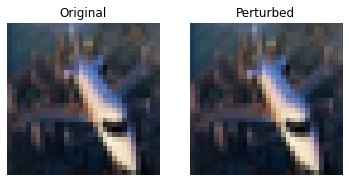

Real class: airplane
Predicted class: bird with 30.0 confidence


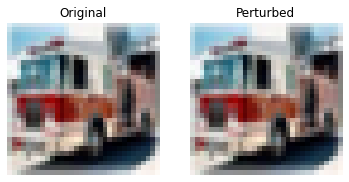

Real class: truck
Predicted class: truck with 96.0 confidence


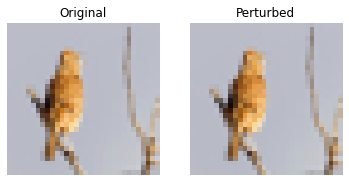

Real class: bird
Predicted class: bird with 39.0 confidence


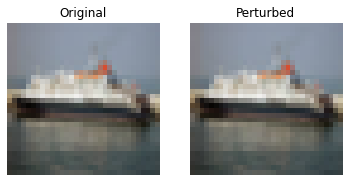

Real class: ship
Predicted class: ship with 77.0 confidence


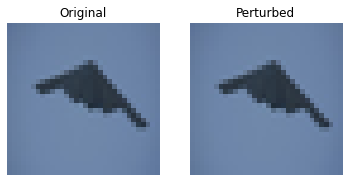

Real class: airplane
Predicted class: airplane with 77.0 confidence


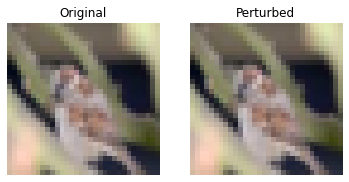

Real class: bird
Predicted class: frog with 40.0 confidence


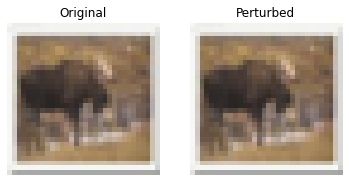

Real class: deer
Predicted class: horse with 61.0 confidence


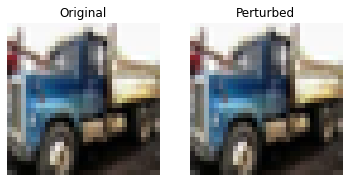

Real class: truck
Predicted class: truck with 90.0 confidence


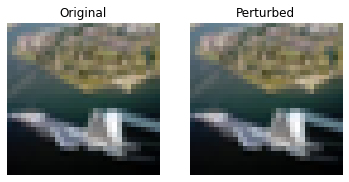

Real class: airplane
Predicted class: ship with 43.0 confidence


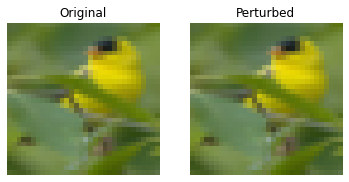

Real class: bird
Predicted class: deer with 38.0 confidence


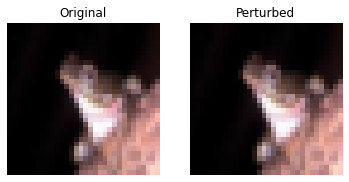

Real class: frog
Predicted class: cat with 35.0 confidence


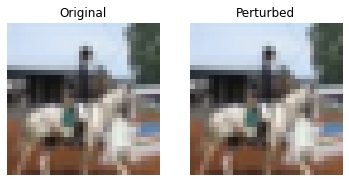

Real class: horse
Predicted class: horse with 37.0 confidence


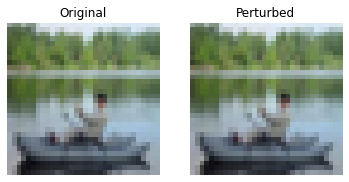

Real class: ship
Predicted class: automobile with 43.0 confidence


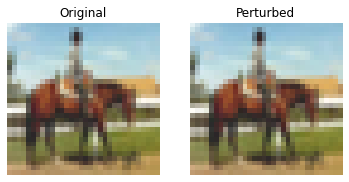

Real class: horse
Predicted class: horse with 83.0 confidence


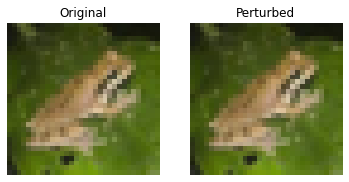

Real class: frog
Predicted class: frog with 68.0 confidence


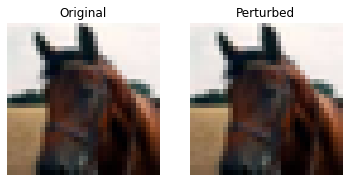

Real class: horse
Predicted class: horse with 47.0 confidence


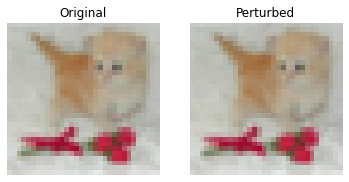

Real class: cat
Predicted class: cat with 28.0 confidence


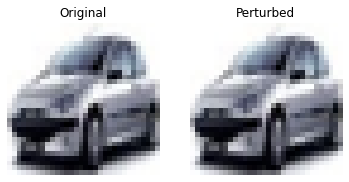

Real class: automobile
Predicted class: automobile with 86.0 confidence


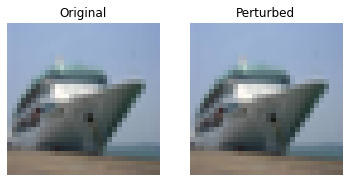

Real class: ship
Predicted class: ship with 53.0 confidence


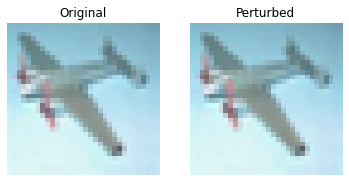

Real class: airplane
Predicted class: airplane with 83.0 confidence


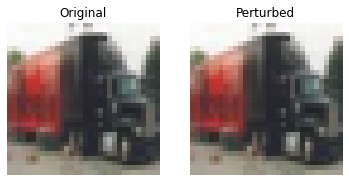

Real class: truck
Predicted class: truck with 92.0 confidence


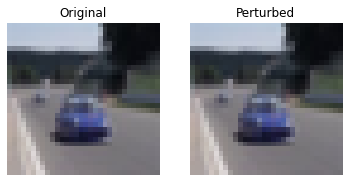

Real class: automobile
Predicted class: ship with 36.0 confidence


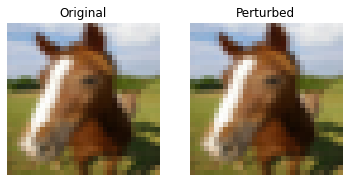

Real class: horse
Predicted class: horse with 74.0 confidence


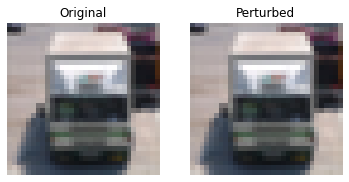

Real class: truck
Predicted class: truck with 41.0 confidence


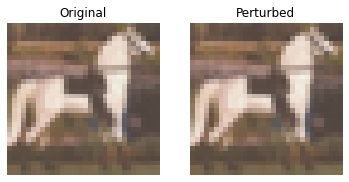

Real class: horse
Predicted class: horse with 52.0 confidence


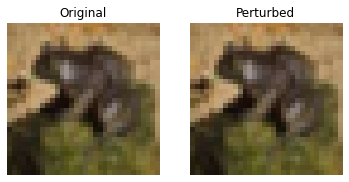

Real class: frog
Predicted class: frog with 53.0 confidence


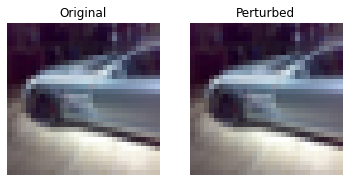

Real class: automobile
Predicted class: automobile with 63.0 confidence


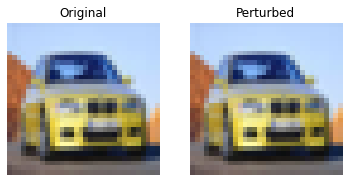

Real class: automobile
Predicted class: automobile with 75.0 confidence


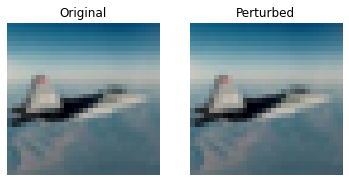

Real class: airplane
Predicted class: airplane with 51.0 confidence


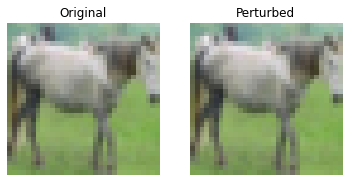

Real class: horse
Predicted class: horse with 81.0 confidence


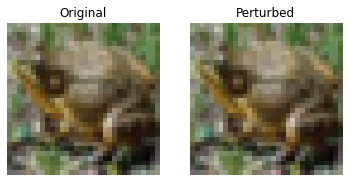

Real class: frog
Predicted class: frog with 59.0 confidence


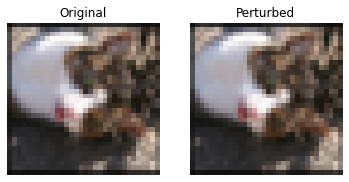

Real class: cat
Predicted class: truck with 40.0 confidence


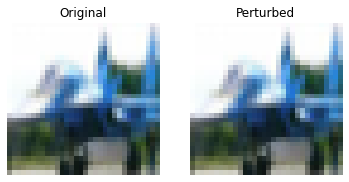

Real class: airplane
Predicted class: truck with 50.0 confidence


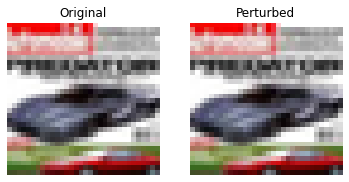

Real class: automobile
Predicted class: automobile with 38.0 confidence


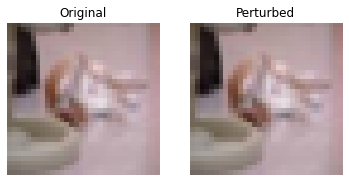

Real class: cat
Predicted class: dog with 29.0 confidence


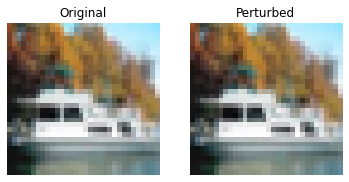

Real class: ship
Predicted class: ship with 86.0 confidence


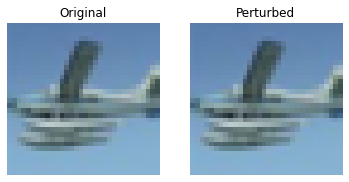

Real class: airplane
Predicted class: airplane with 63.0 confidence


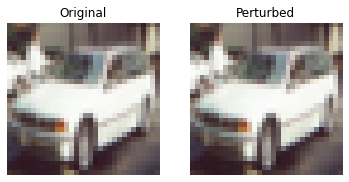

Real class: automobile
Predicted class: automobile with 92.0 confidence


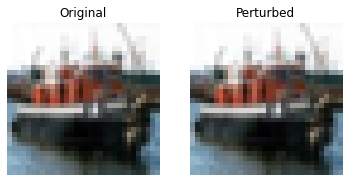

Real class: ship
Predicted class: ship with 65.0 confidence


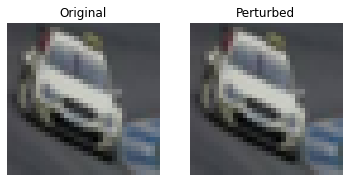

Real class: automobile
Predicted class: automobile with 40.0 confidence


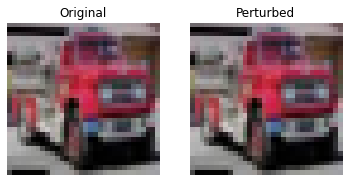

Real class: truck
Predicted class: truck with 76.0 confidence


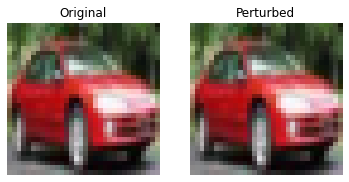

Real class: automobile
Predicted class: automobile with 92.0 confidence


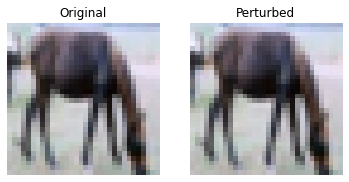

Real class: horse
Predicted class: horse with 90.0 confidence
Robust ELU CNN original Accuracy 0.715%
Robust ELU CNN Accuracy0.715%
time: 4min 22s


In [36]:
# Robustness Accuracy on train set for rob_elu_cnn model, set plot=True if you want image-wise stats
nfool = 0
nacc = 0
for perturbed_img in x_train_sample:
    
    original_idx = find_original_img(perturbed_img, set='train')
    nacc += attack_succeed(x_train[original_idx], original_idx, x_train[original_idx], rob_elu_cnn, plot=False, set='train') 
    nfool += attack_succeed(x_train[original_idx], original_idx, perturbed_img, rob_elu_cnn, plot=True, set='train') 

print("Robust ELU CNN original Accuracy {}%\nRobust ELU CNN Accuracy{}%".format(nacc/200, nfool/200))